In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb

import math
import seaborn as sns

#PCA
from sklearn.decomposition import PCA
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo #test de esfericidad de Bartlett, índice KMO

#Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score #índice CH

#Regresión y clasificación
import statsmodels.formula.api as smf
#Test de Bresuch-Pagan
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor #VIF: factores de inflación de la varianza

# PREPROCESAMIENTO / ANÁLISIS DESCRIPTIVO

## 1. Separar en 2 dataframes según nivelPrograma: grado y master + master propio

In [5]:
df = pd.read_excel("Datos_TFM.xlsx")

In [7]:
df_grado = df[df['nivelPrograma'] == 'grado'].drop(columns=['pregunta1', 'pregunta2', 'pregunta3', 'pregunta4', 
                                                            'pregunta5', 'pregunta6', 'pregunta7','pregunta8', 
                                                            'pregunta9', 'pregunta10', 'pregunta11', 'pregunta12', 
                                                            'pregunta13','pregunta14', 'pregunta15', 'pregunta16', 
                                                            'pregunta17', 'pregunta18', 'pregunta19', 'nivelPrograma'])

df_master = df[df['nivelPrograma'].isin(['máster', 'mpropio'])].drop(columns=['pregunta1', 'pregunta2', 'pregunta3', 'pregunta4', 'pregunta5', 'pregunta6', 'pregunta7',
                                                                              'pregunta8', 'pregunta9', 'pregunta10', 'pregunta11', 'pregunta12', 'pregunta13',
                                                                              'pregunta14', 'pregunta15', 'pregunta16','pregunta17','respuesta17', 'pregunta18', 'respuesta18',
                                                                              'pregunta19','respuesta19', 'nivelPrograma'])

In [9]:
nuevos_nombres_master = {
    'respuesta1': 'puntualidad', #En qué porcentaje este profesor ha sido puntual.
    'respuesta2': 'asistencia', #En qué porcentaje este profesor ha asistido a sus clases.
    'respuesta3': 'dominio_materia', #El profesor domina esta materia.
    'respuesta4': 'claridad_explicaciones', #El profesor es claro en sus explicaciones.
    'respuesta5': 'materiales_actualizados', #Las exposiciones y materiales que da el profesor están actualizados
    'respuesta6': 'recursos_adecuados', #El profesor utiliza materiales y recursos (casos, ejercicios, lecturas, bibliografía) adecuados para las actividades que propone
    'respuesta7': 'fomento_participacion', #Fomenta la participación del alumno en clase
    'respuesta8': 'accesibilidad', #El profesor es accesible y está dispuesto a ayudar al alumno
    'respuesta9': 'percepcion_aprendizaje', #Creo que estoy aprendiendo con este profesor
    'respuesta10': 'recomendacion', #Recomendaría este profesor a futuros alumnos
    'respuesta11': 'juicio_global', #Juicio global que me merece como profesor
    'respuesta12': 'coherencia_programacion', #La programación de la asignatura (objetivos, metodología, actividades, evaluaciones) es coherente y está bien organizada
    'respuesta13': 'coherencia_objetivos_evaluacion', #Existe coherencia entre los objetivos de la asignatura y los sistemas de evaluación
    'respuesta14': 'coordinacion_otras_materias', #La materia está bien coordinada con el resto de materias del máster
    'respuesta15': 'dificultad_adecuada', #La cantidad y dificultad de la materia están adecuadas al nivel real de los alumnos
    'respuesta16': 'valoracion_global_materia' #Valoración global de esta materia
}

nuevos_nombres_grado = {
    'respuesta1': 'asistencia', # En qué porcentaje este profesor ha asistido a sus clases.
    'respuesta2': 'puntualidad', #En qué porcentaje este profesor ha sido puntual.
    'respuesta3': 'dominio_materia', #El profesor domina esta materia.
    'respuesta4': 'claridad_explicaciones', #El profesor es claro en sus explicaciones.
    'respuesta5': 'claridad_programacion_asignatura', #El profesor ha explicado con claridad la programación de la asignatura (objetivos, contenidos, metodología, sistemas de evaluación…).
    'respuesta6': 'distribucion_temporal_temas', #El profesor lleva una adecuada distribución del reparto de temas a lo largo del semestre/curso.
    'respuesta7': 'materiales_actualizados', #Las exposiciones y materiales están actualizados.
    'respuesta8': 'recursos_adecuados', #El profesor utiliza materiales y recursos (casos, ejercicios, lecturas, bibliografía) adecuados para las actividades que propone.
    'respuesta9': 'actividades_objetivos', #Las actividades propuestas por el profesor para realizar dentro y fuera del aula favorecen la consecución de los objetivos de la asignatura.
    'respuesta10': 'informacion_progreso', #El profesor proporciona a los alumnos información personalizada y útil sobre el progreso del alumno.
    'respuesta11': 'ambiente_respeto', #El profesor se relaciona con los alumnos en un ambiente de cercanía y respeto.
    'respuesta12': 'accesibilidad', #El profesor es accesible y está dispuesto a ayudar al alumno.
    'respuesta13': 'formacion_integral', #Además de la formación técnica, este profesor ha contribuido a mi formación integral.
    'respuesta14': 'percepcion_aprendizaje', #Creo que estoy aprendiendo con este profesor.
    'respuesta15': 'recomendacion', #Recomendaría este profesor a futuros alumnos.
    'respuesta16': 'juicio_global', #Juicio global que me merece como profesor.
    'respuesta17': 'coherencia_programacion', #La programación de la asignatura (objetivos, metodología, actividades, evaluaciones) es coherente y está bien organizada.
    'respuesta18': 'coherencia_objetivos_evaluacion', #Existe coherencia entre los objetivos de la asignatura y los sistemas de evaluación.
    'respuesta19': 'horas_estudio_semana' #Horas de trabajo y estudio a la semana en esta asignatura (sin contar las horas de clase).
}

df_master = df_master.rename(columns=nuevos_nombres_master)

df_grado = df_grado.rename(columns=nuevos_nombres_grado)


In [11]:
#Crear columna de porcentaje de respuesta
df_grado["porcentajeRespuesta"] = (df_grado["numeroRespuestas"] / df_grado["numeroAlumnos"])

df_grado = df_grado.drop(columns=["numeroRespuestas"]) #Eliminar columna de número de respuestas

df_master["porcentajeRespuesta"] = (df_master["numeroRespuestas"] / df_master["numeroAlumnos"])

df_master = df_master.drop(columns=["numeroRespuestas"]) #Eliminar columna de número de respuestas

In [13]:
#Dicotomizar variable de tipo de evaluación
df_grado["formatoEvaluacion"] = df_grado["formatoEvaluacion"].replace({"papel":1, "online":0})

df_master["formatoEvaluacion"] = df_master["formatoEvaluacion"].replace({"papel":1, "online":0})

C:\Users\javie\AppData\Local\Temp\ipykernel_22512\2550688846.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_grado["formatoEvaluacion"] = df_grado["formatoEvaluacion"].replace({"papel":1, "online":0})
C:\Users\javie\AppData\Local\Temp\ipykernel_22512\2550688846.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_master["formatoEvaluacion"] = df_master["formatoEvaluacion"].replace({"papel":1, "online":0})


## 2. Calcular el valor medio de las respuestas a la encuesta según idDocencia. Los demás campos dejarlos igual (son iguales para un mismo idDocencia)

In [15]:
df_grado = df_grado.groupby('idDocencia').agg({
    **{col: 'mean' for col in df_grado.select_dtypes(include='number').columns}, #Para las columnas numéricas, hace la media
    **{col: 'first' for col in df_grado.select_dtypes(include='object').columns} #Para las columnas de texto, escoge el primer valor pues es el mismo en todas las filas
})

df_master = df_master.groupby('idDocencia').agg({
    **{col: 'mean' for col in df_master.select_dtypes(include='number').columns},
    **{col: 'first' for col in df_master.select_dtypes(include='object').columns}
})

## 3. Hacer los gráficos descriptivos de todas las variables + la variable dependiente (pregunta 16 en grado y pregunta 11 en master)

In [506]:
#Función para graficar variables no comunes entre ambos 
def graficar_variables_nocomunes(df, continuas=None, tipo=None): #Las unicas variables que no son comunes son ciertas numéricas continuas
    """
    Genera gráficos para las variables según su tipo:
    - Histograma para variables continuas.
    
    Parámetros:
    - continuas: lista de variables numéricas continuas.
    """
    for col in continuas:
    # Histograma para variables numéricas continuas
        plt.figure(figsize=(8,5))
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.title(f'Distribución de la variable "{nombres_graficos.get(col)}" para {tipo}')
        plt.xlabel("Valoración")
        plt.ylabel('Frecuencia')
        
        plt.show()

In [26]:
def graficar_variables_comunes(df1, df2, discretas=None, continuas=None, categoricas=None):
    """
    Genera gráficos para las variables según su tipo:
    - Gráfico de tarta para variables categóricas.
    - Histograma para variables continuas.
    - Gráfico de barras para para variables discretas.
    
    Parámetros:
    - discretas: lista de variables numéricas discretas.
    - continuas: lista de variables numéricas continuas.
    - variables: lista de variables categóricas.
    """
    
    discretas = discretas or []
    continuas = continuas or []
    categoricas = categoricas or []

    for col in discretas + continuas + categoricas: #Para iterar en todas las variables
    
        fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #Crear una figura con dos gráficos
        
        for i, df in enumerate([df1, df2]): #Para cada gráfico de cada variable en cada figura
            valores = df[col].value_counts()
            
            if col in categoricas:
                if pd.api.types.is_float_dtype(df[col]): 
                    df[col] = df[col].astype(int) #Si alguna variable categórica está como "float", la transforma en "int"
                axes[i].pie(valores, labels=valores.index, autopct='%.1f%%')
            
            elif col in discretas:
                axes[i].bar(valores.index, valores.values)
                axes[i].set_xlabel("Valores")
                axes[i].set_ylabel('Frecuencia')
    
            elif col in continuas:
                axes[i].hist(df[col].dropna(), bins=30, edgecolor='black')
                axes[i].set_xlabel("Valores")
                axes[i].set_ylabel('Frecuencia')
        
        fig.suptitle(f'Distribución de la variable "{nombres_graficos.get(col)}" para grado y máster, respectivamente')
        plt.tight_layout()

        plt.show()

In [508]:
discretas = ["numeroAlumnos"]

continuas = ['notaMedia', 'Porcentaje_suspensos', 'Porcentaje_aprobados', 'Porcentaje_notables', 
             'Porcentaje_sobresalientes', 'Porcentaje_MH', 'asistencia', 'puntualidad', 
             'dominio_materia', 'claridad_explicaciones', 'materiales_actualizados', 'recursos_adecuados', 
             'accesibilidad', 'percepcion_aprendizaje', 'recomendacion', 'juicio_global', 
             'coherencia_programacion', 'coherencia_objetivos_evaluacion', 'porcentajeRespuesta']

continuas_grado = ['claridad_programacion_asignatura', 'distribucion_temporal_temas', 
                    'actividades_objetivos', 'informacion_progreso', 'ambiente_respeto', 
                    'formacion_integral', 'horas_estudio_semana']

continuas_master = ['fomento_participacion', 'coordinacion_otras_materias', 
                    'dificultad_adecuada', 'valoracion_global_materia']

categoricas = ['Nacionalidad_espanol', 'Profesor_Mujer', 'cursoAcademico', 'Curso',
       'Idioma_Espanol', 'dedicacionProfesor', 'cuatrimestre', 'formatoEvaluacion','dedicacionProfesor']

In [510]:
#Nombres más adecuados para los gráficos
nombres_graficos = {
    # Numéricas
    'numeroAlumnos': 'Número de alumnos matriculados',
    'notaMedia': 'Nota media',
    'Porcentaje_suspensos': 'Porcentaje de suspensos',
    'Porcentaje_aprobados': 'Porcentaje de aprobados',
    'Porcentaje_notables': 'Porcentaje de notables',
    'Porcentaje_sobresalientes': 'Porcentaje de sobresalientes',
    'Porcentaje_MH': 'Porcentaje de Matrículas de Honor',
    'asistencia': 'Asistencia',
    'puntualidad': 'Puntualidad',
    'dominio_materia': 'Dominio de la materia',
    'claridad_explicaciones': 'Claridad de las explicaciones',
    'claridad_programacion_asignatura': 'Claridad en la programación de la asignatura',
    'distribucion_temporal_temas': 'Distribución temporal de los temas',
    'materiales_actualizados': 'Actualización de los materiales',
    'recursos_adecuados': 'Adecuación de los recursos',
    'actividades_objetivos': 'Actividades alineadas con los objetivos',
    'informacion_progreso': 'Información sobre el progreso',
    'ambiente_respeto': 'Ambiente de respeto en clase',
    'accesibilidad': 'Accesibilidad del profesorado',
    'formacion_integral': 'Contribución a la formación integral',
    'percepcion_aprendizaje': 'Percepción del aprendizaje',
    'recomendacion': 'Recomendación de la asignatura',
    'juicio_global': 'Valoración global del profesor',
    'coherencia_programacion': 'Coherencia en la programación',
    'coherencia_objetivos_evaluacion': 'Coherencia entre objetivos y evaluación',
    'horas_estudio_semana': 'Horas de estudio por semana',
    'formatoEvaluacion': 'Formato de evaluación',
    'porcentajeRespuesta': 'Porcentaje de respuesta a la encuesta',
    'fomento_participacion': 'Fomento de la participación',
    'coordinacion_otras_materias': 'Coordinación con otras materias',
    'dificultad_adecuada': 'Dificultad adecuada de la asignatura',
    'valoracion_global_materia': 'Valoración global de la materia',
    
    # Categóricas
    'Nacionalidad_espanol': 'Nacionalidad española',
    'Profesor_Mujer': 'Profesor mujer',
    'cursoAcademico': 'Curso académico',
    'Curso': 'Curso',
    'Idioma_Espanol': 'Idioma español',
    'dedicacionProfesor': 'Dedicación del profesor',
    'cuatrimestre': 'Cuatrimestre'
}

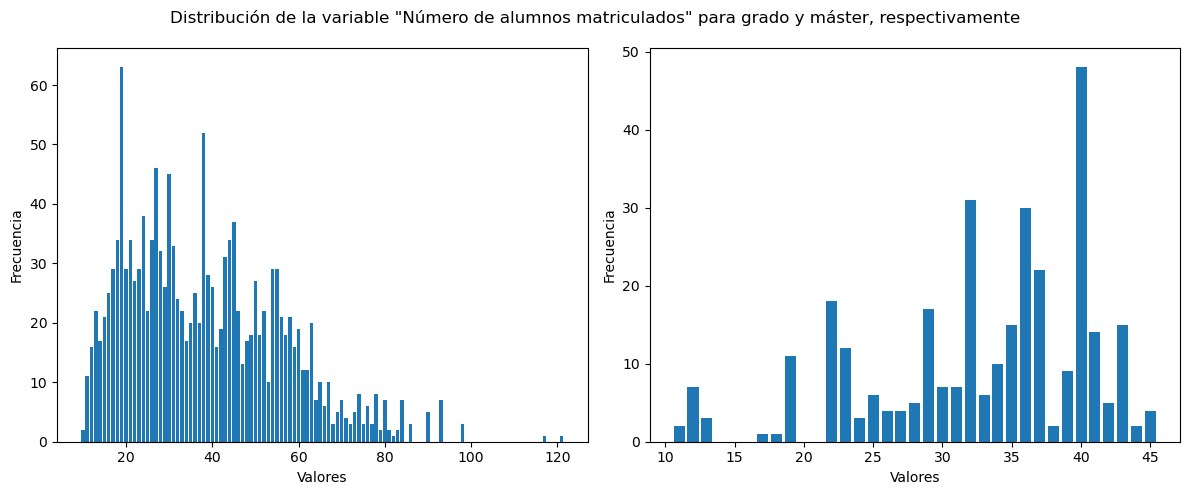

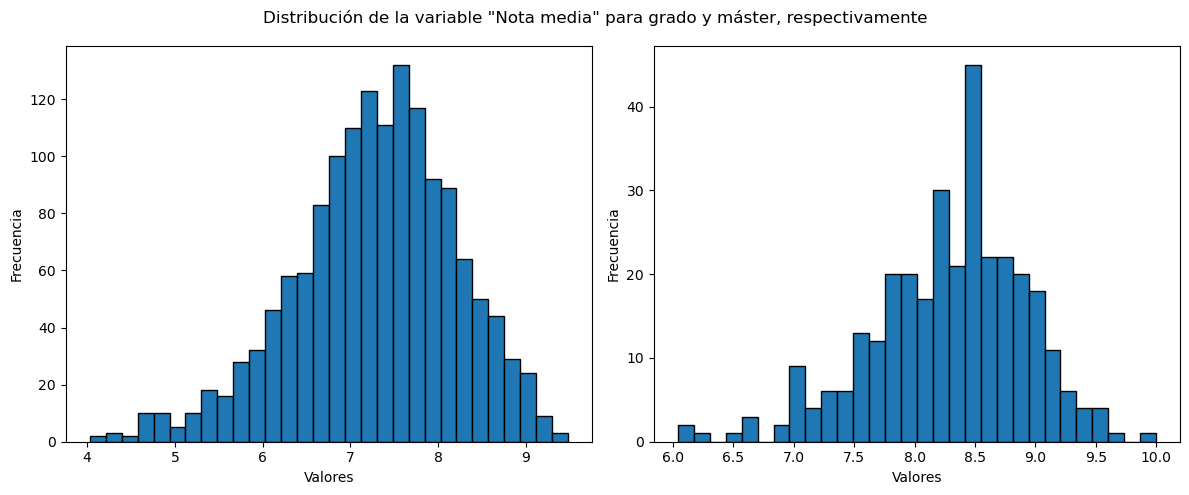

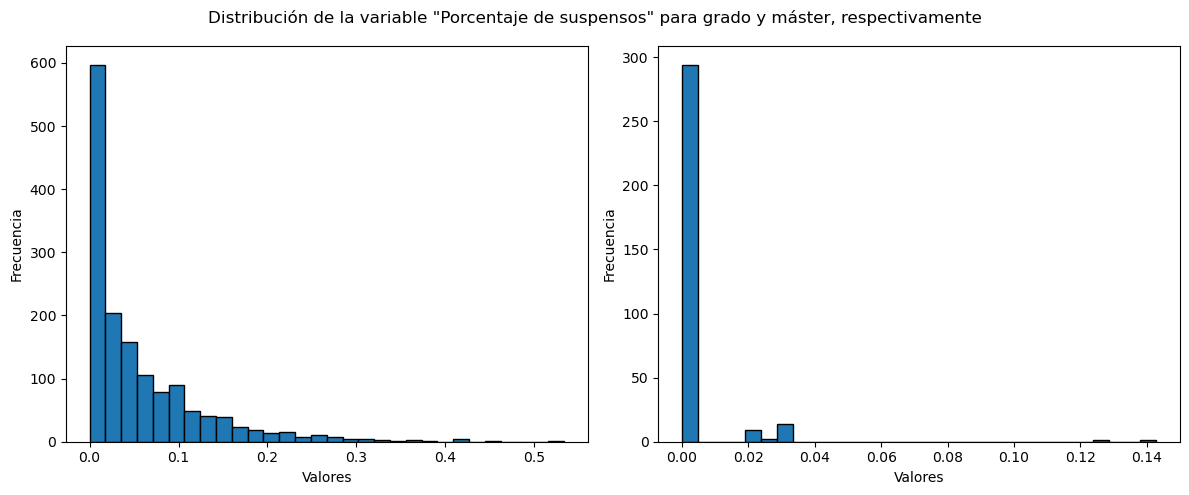

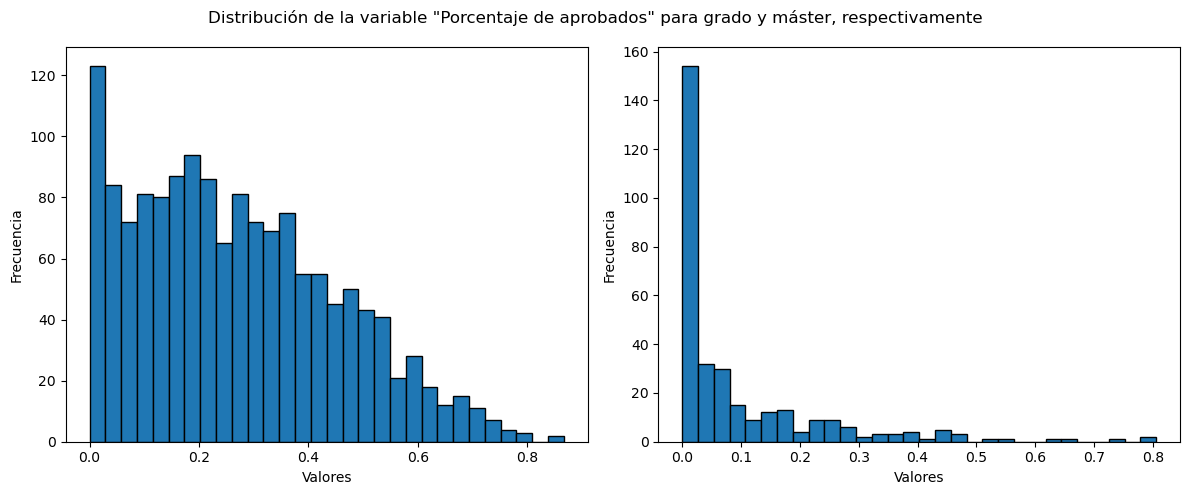

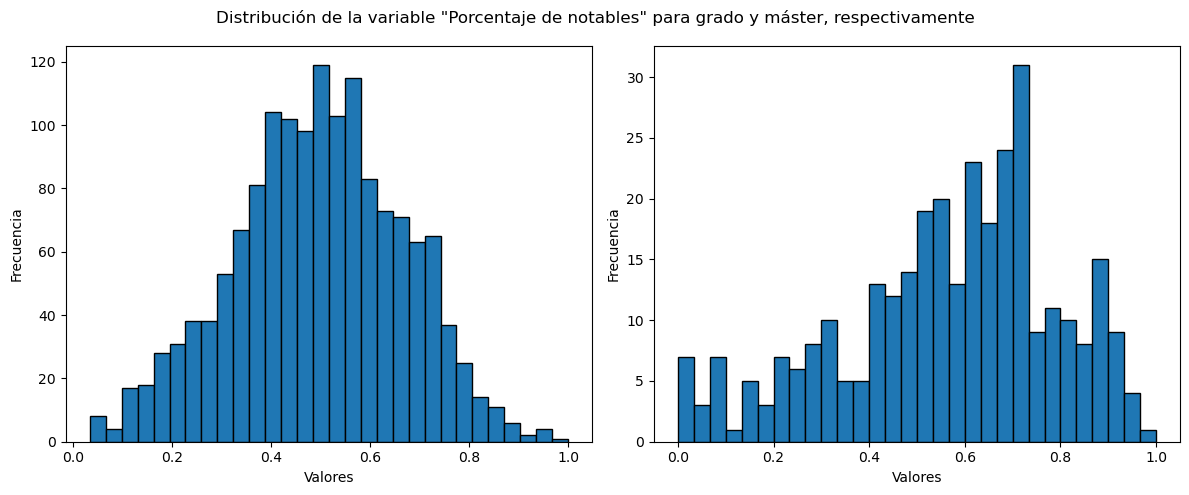

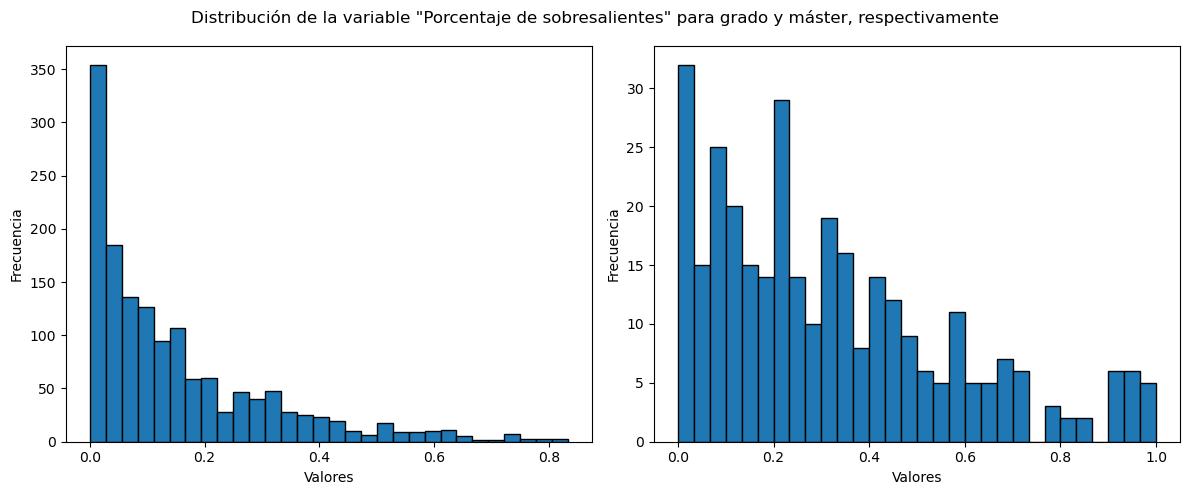

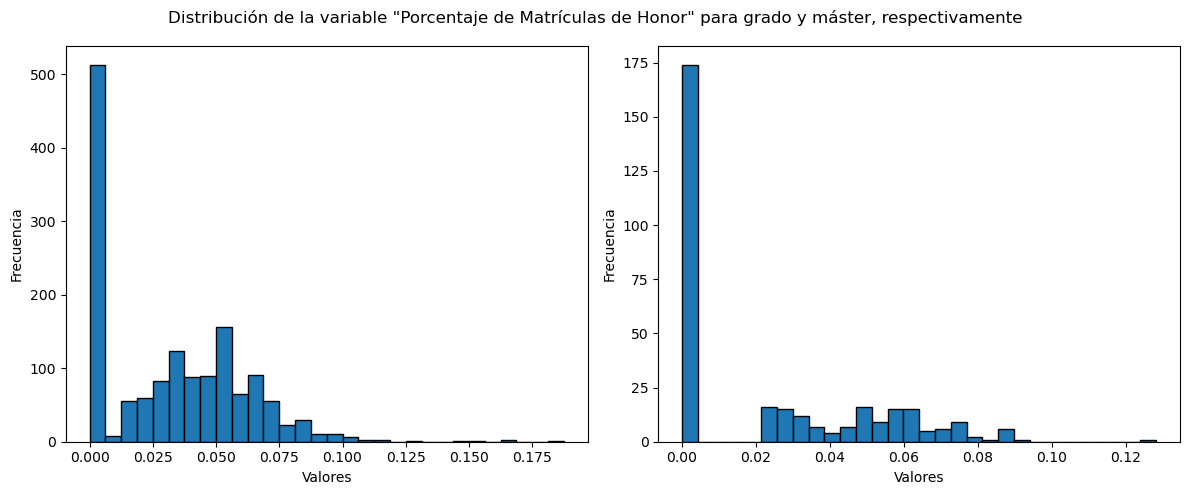

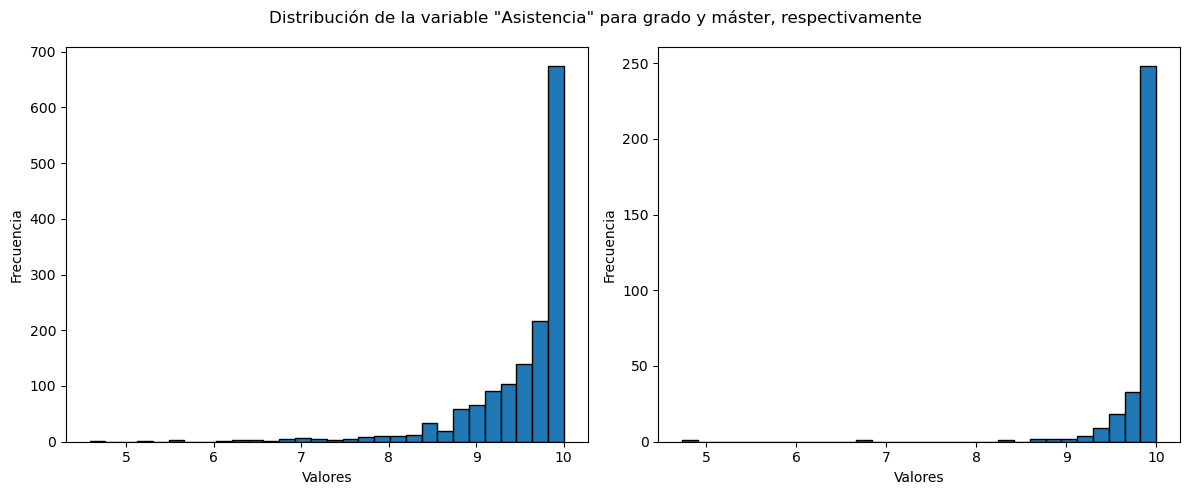

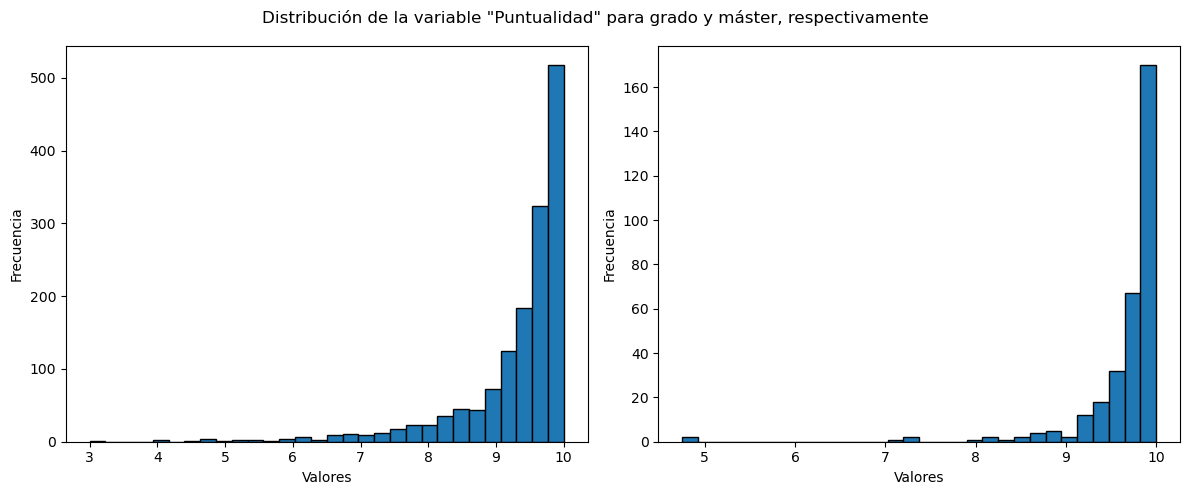

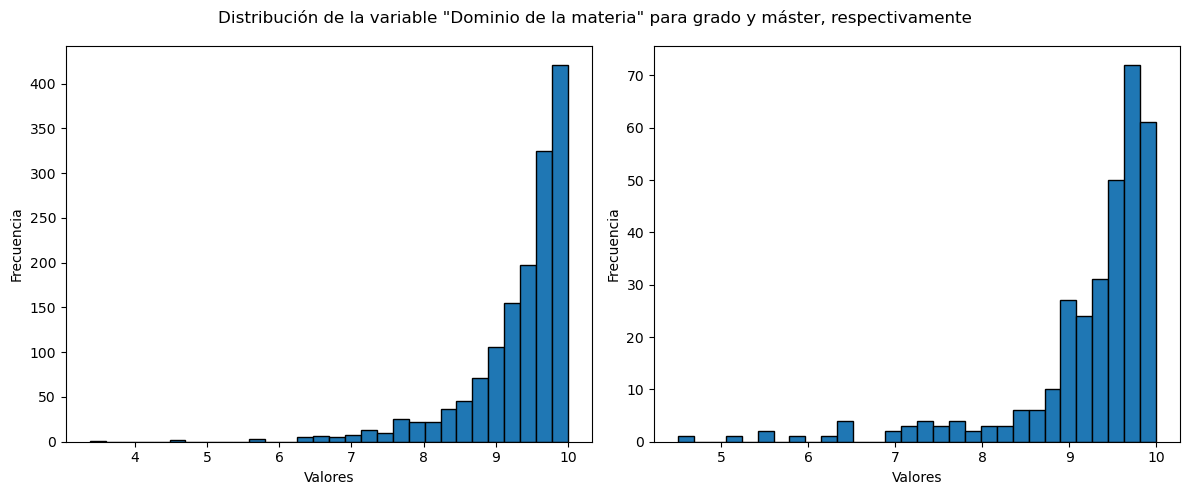

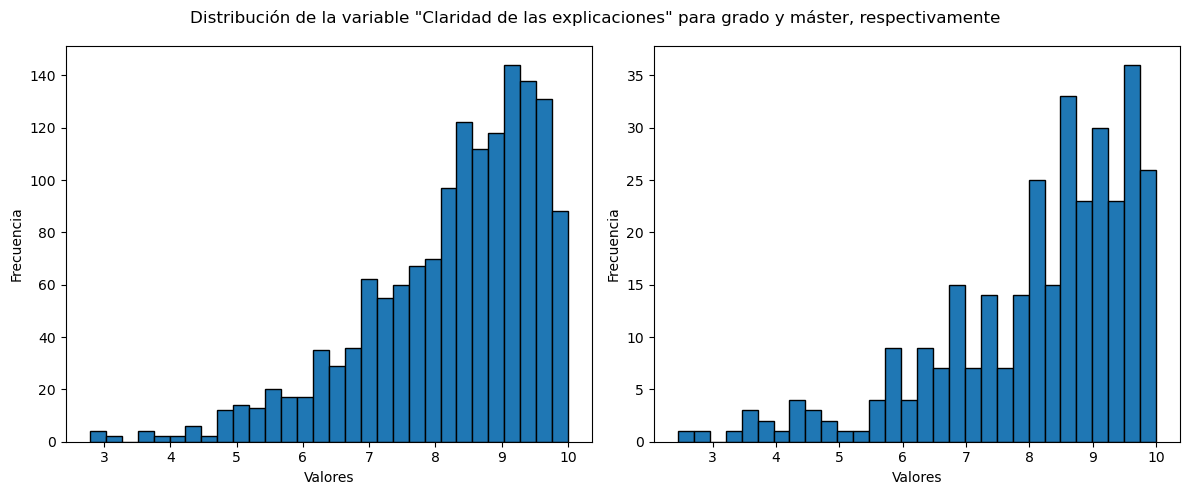

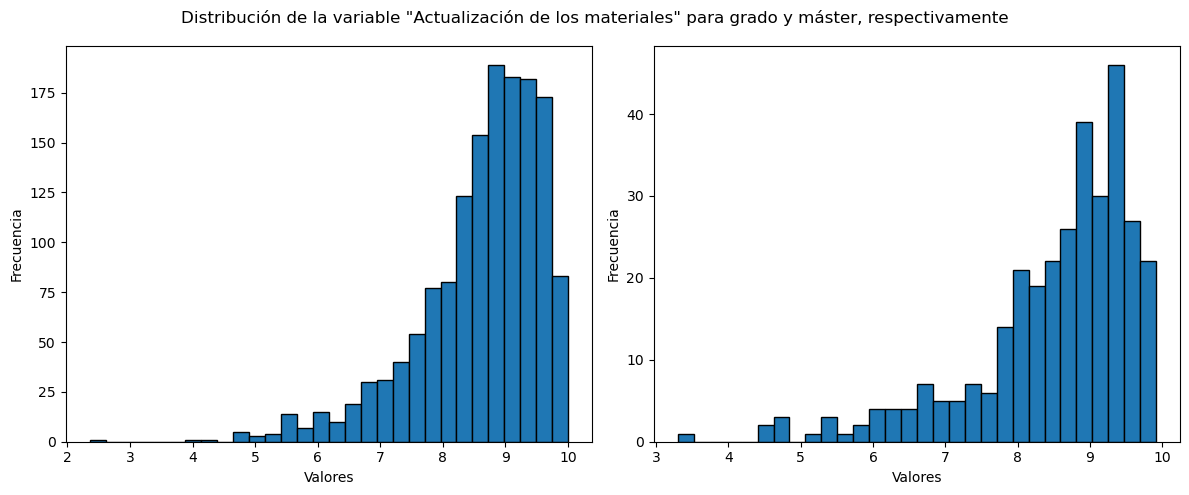

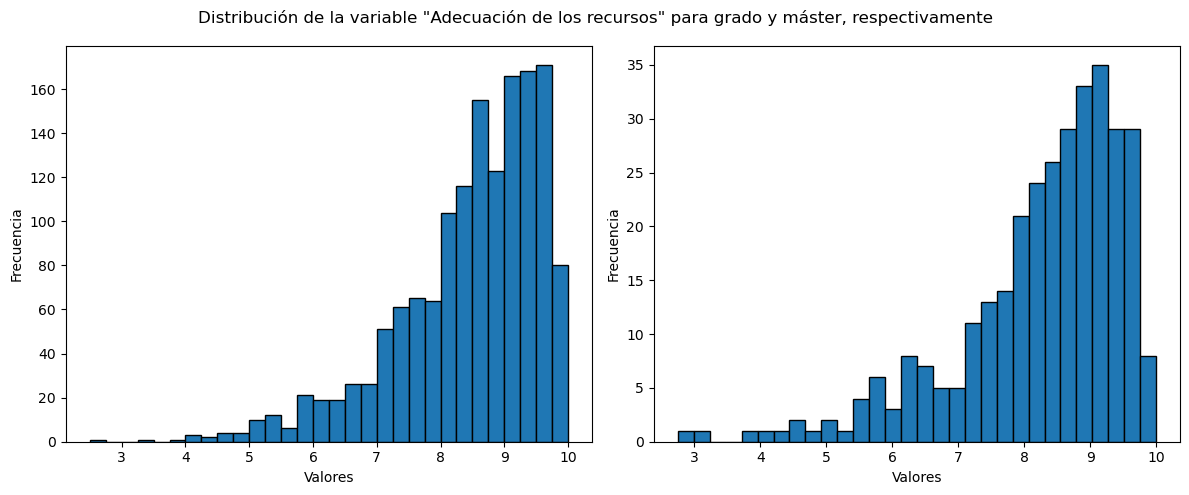

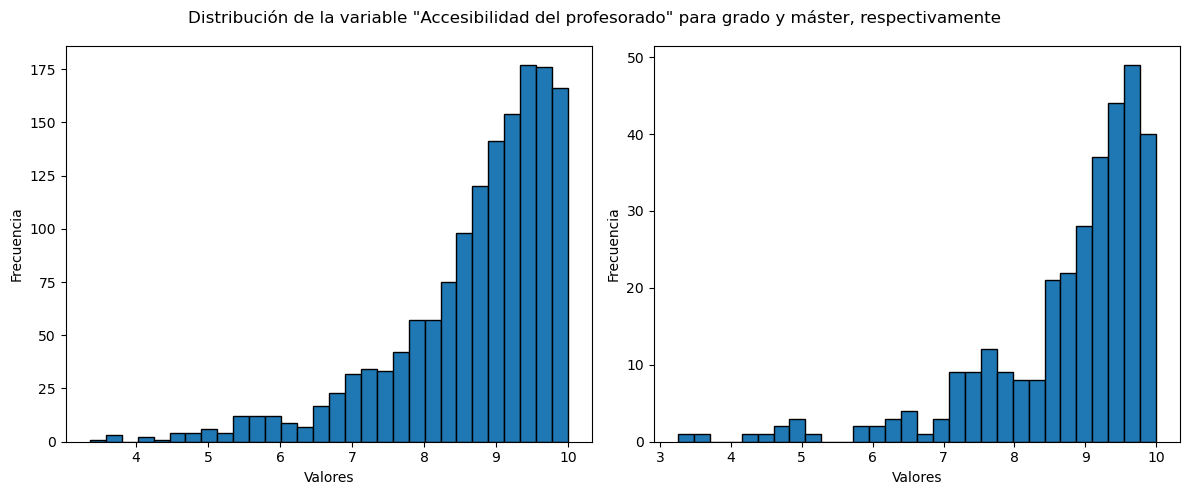

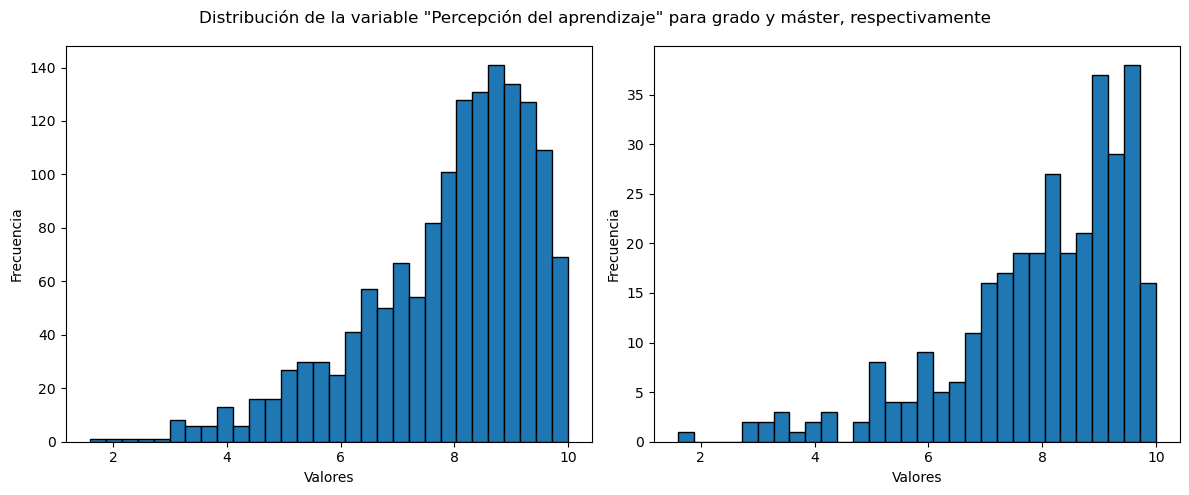

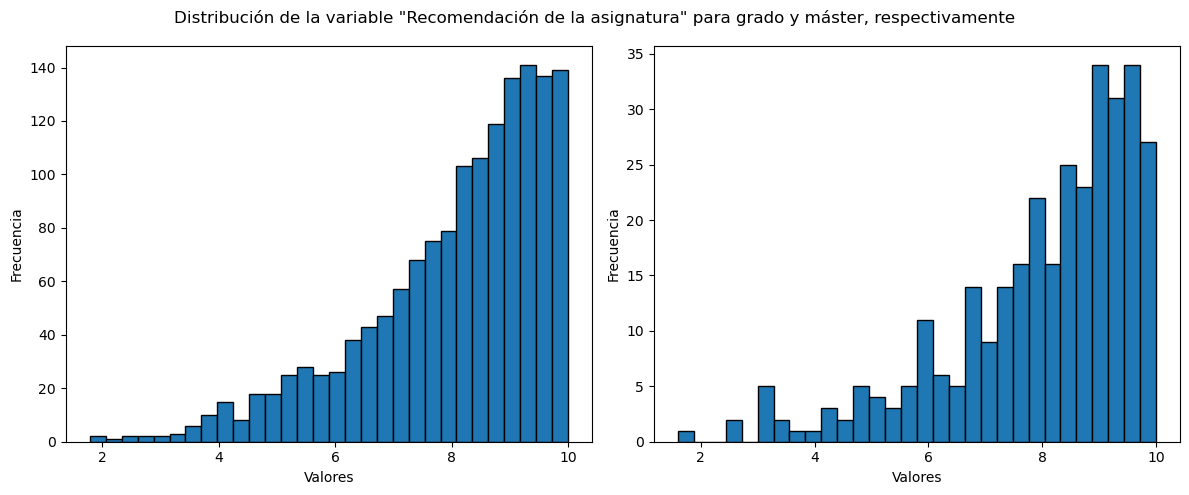

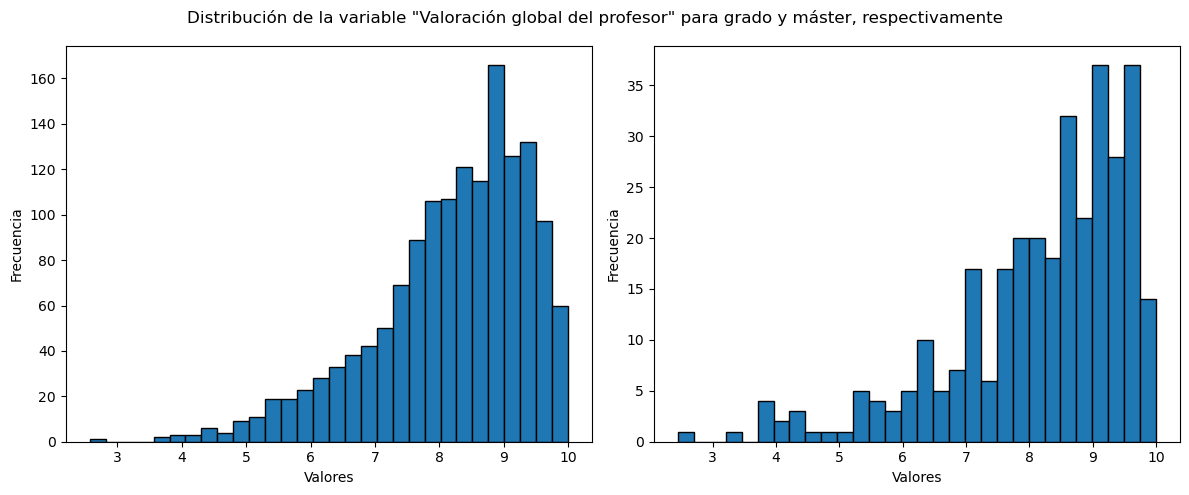

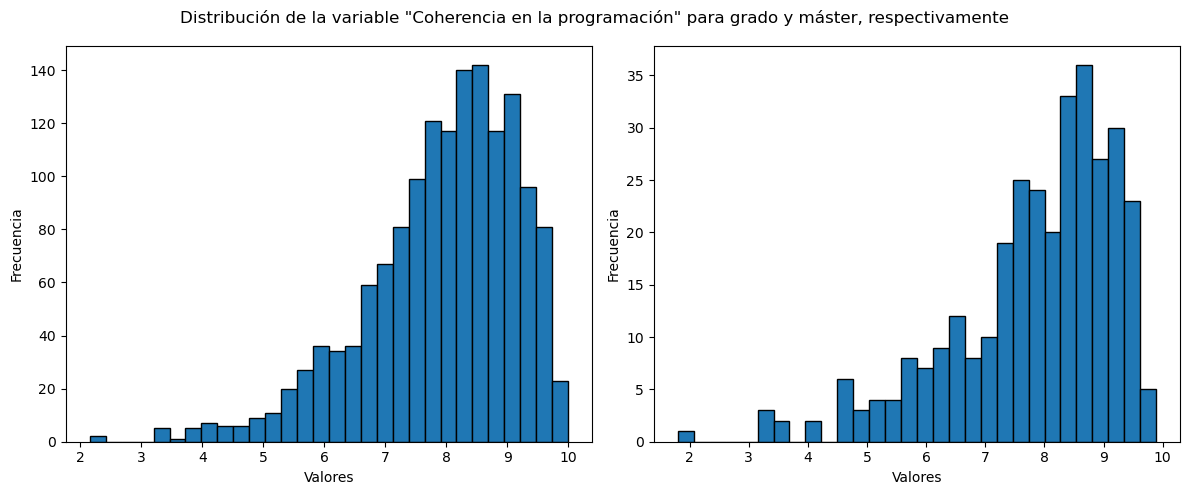

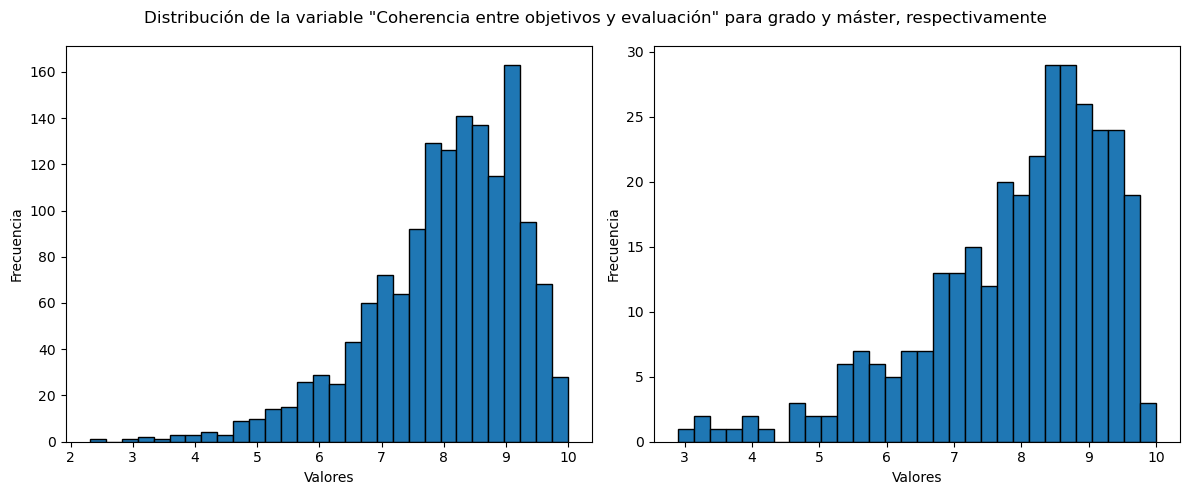

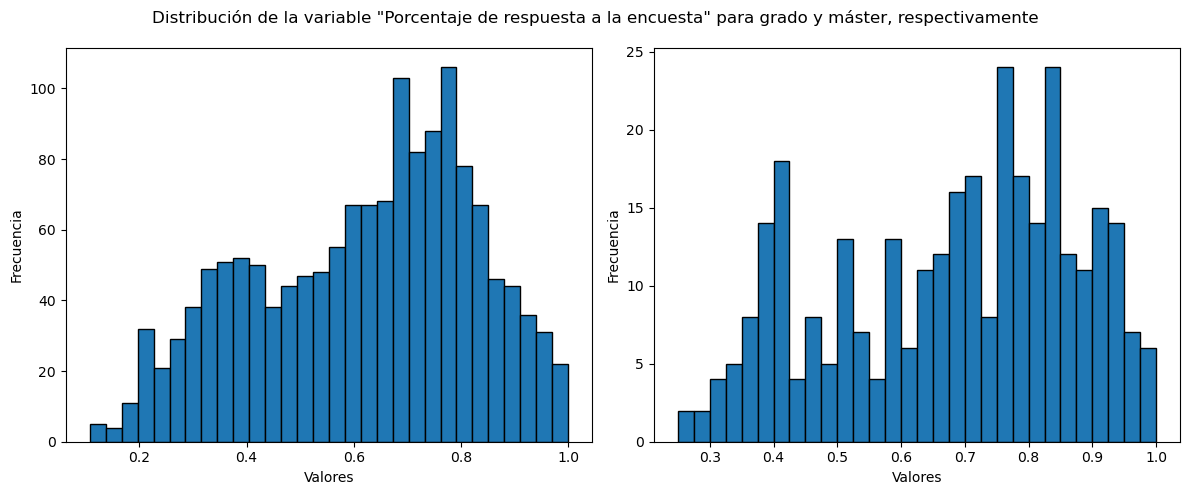

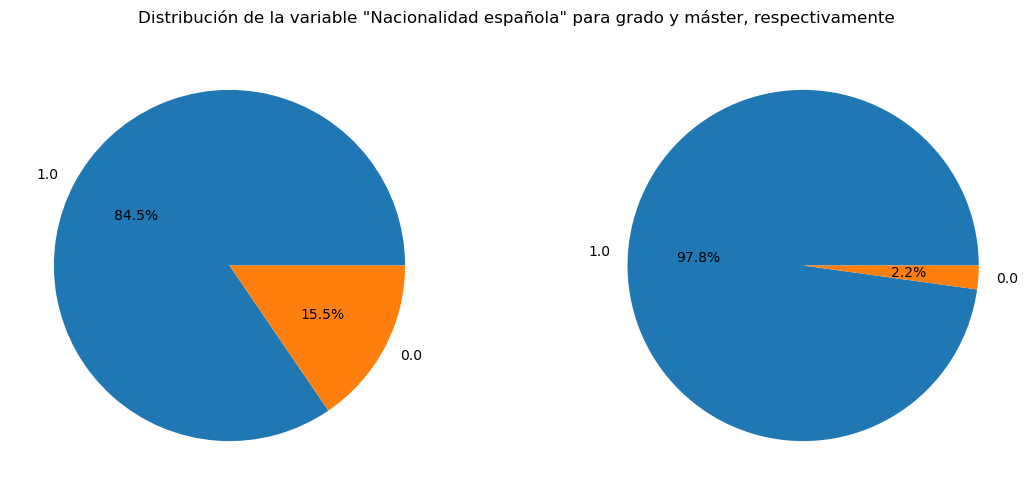

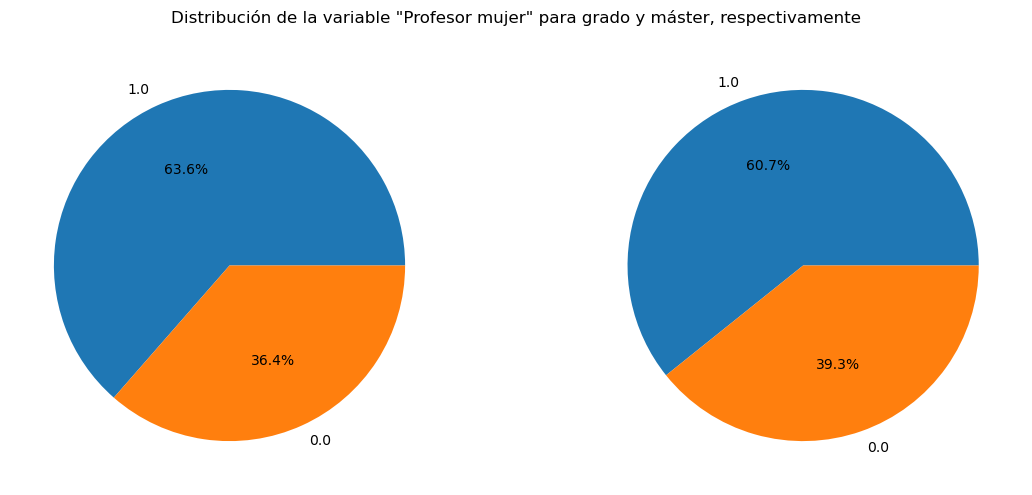

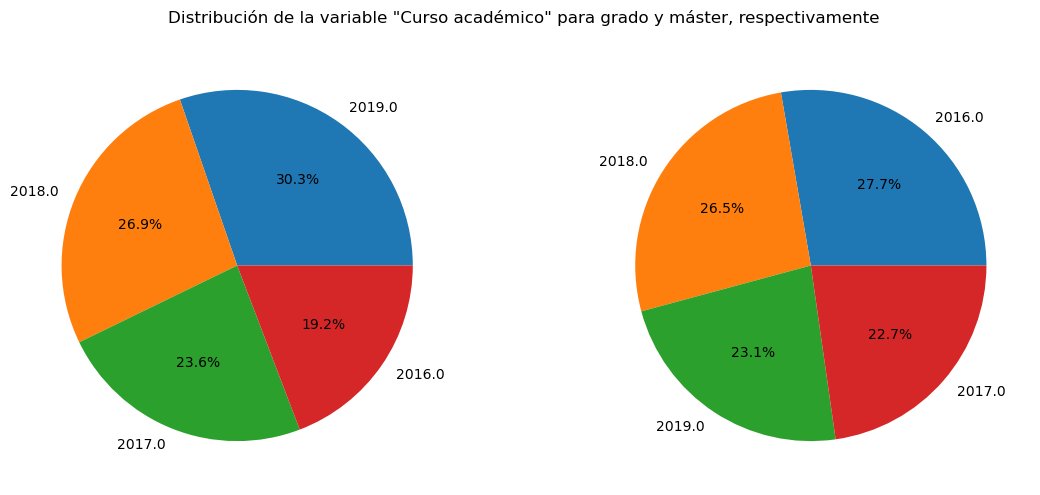

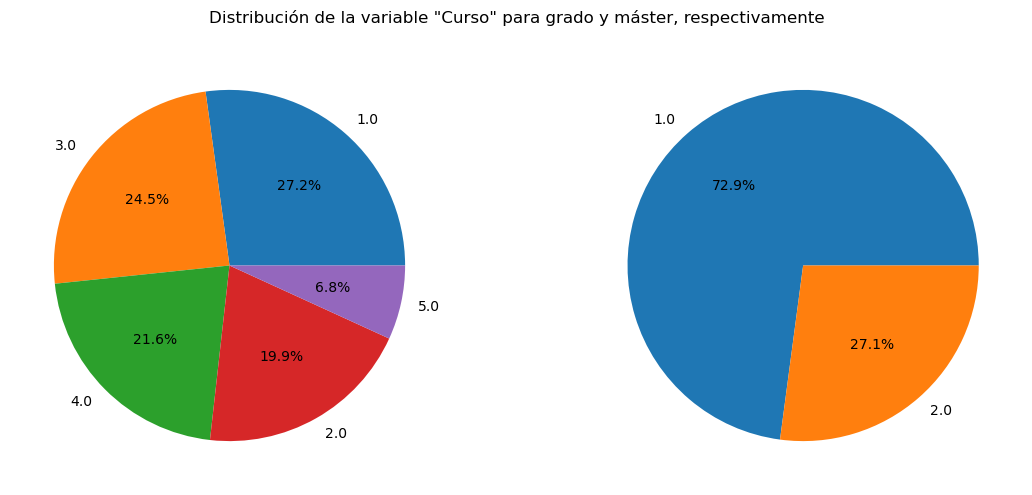

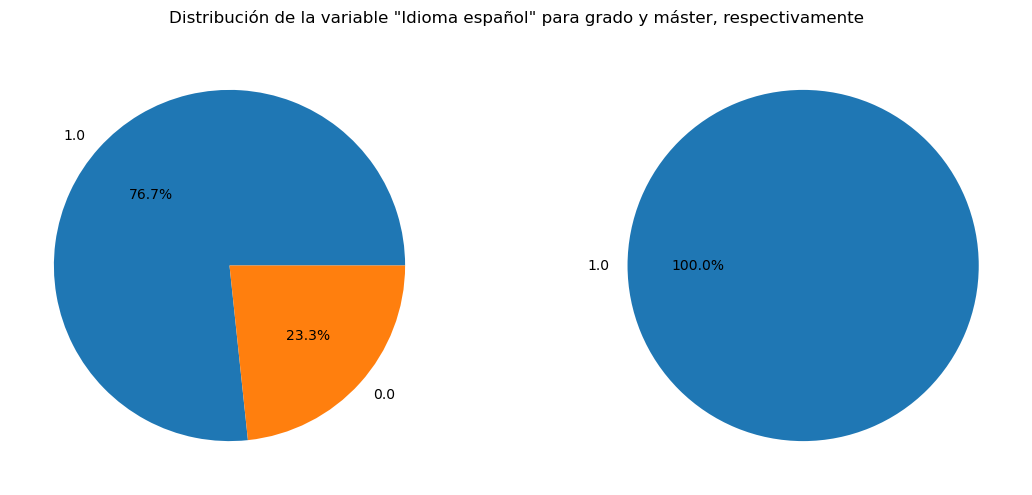

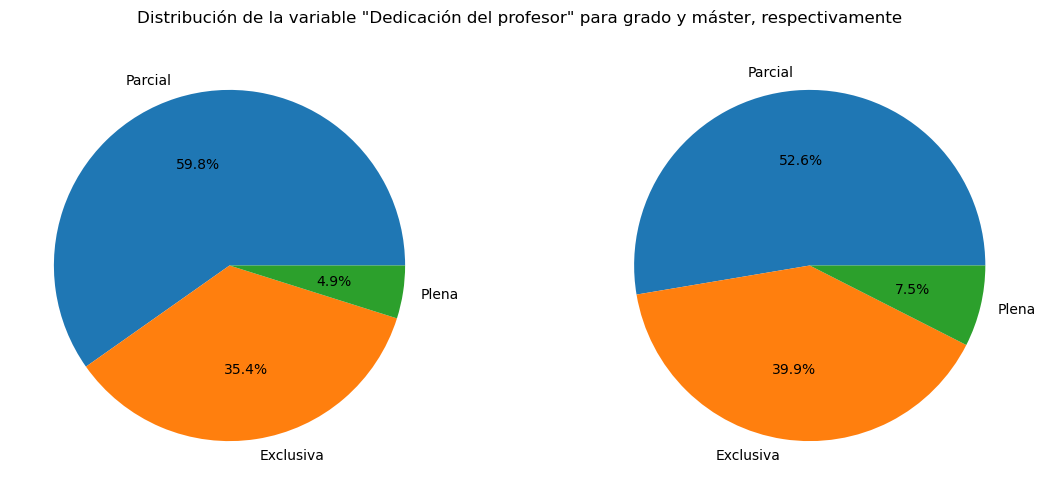

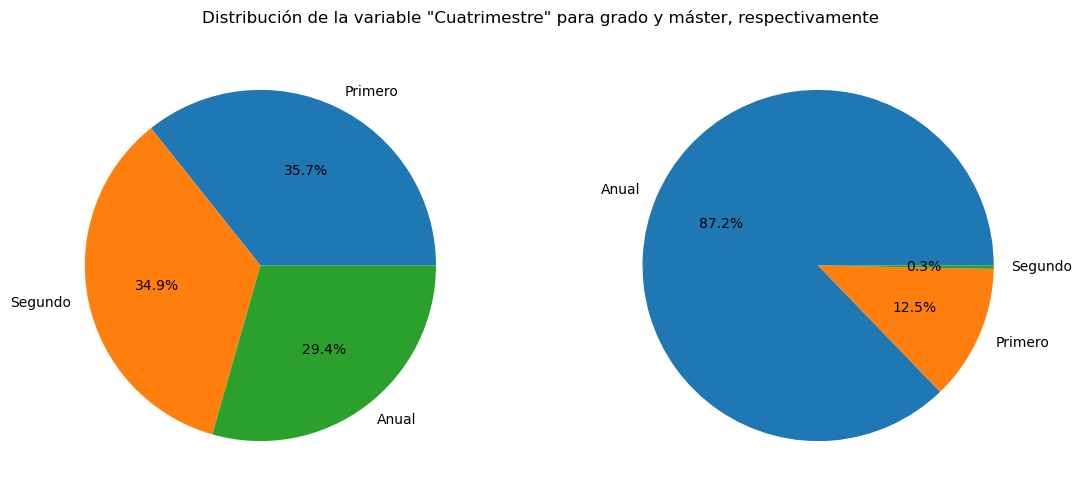

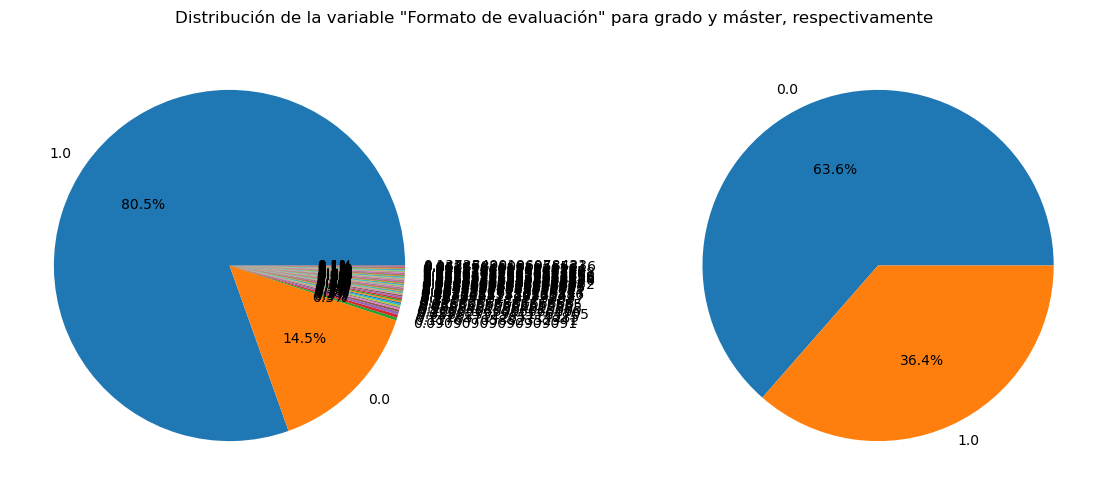

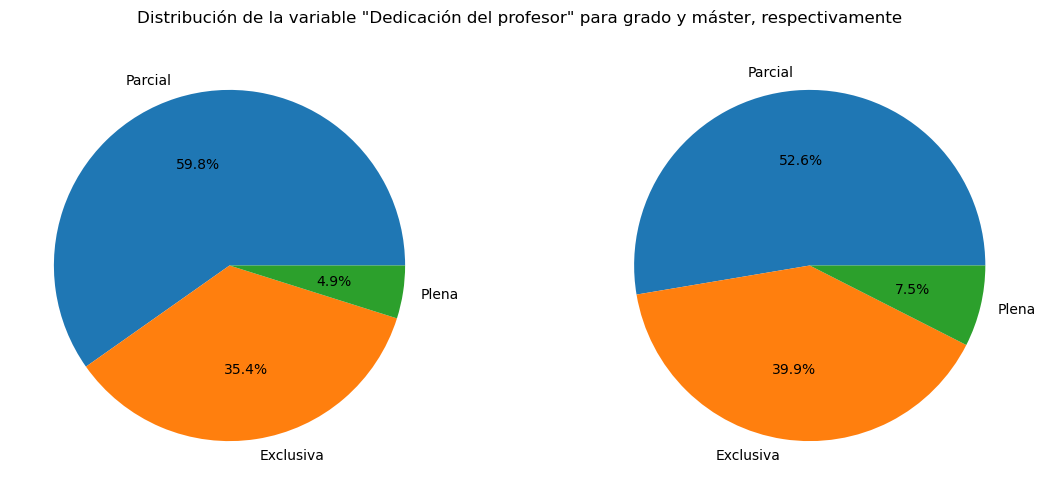

In [28]:
graficar_variables_comunes(df_grado, df_master, discretas=discretas, continuas=continuas, categoricas=categoricas)

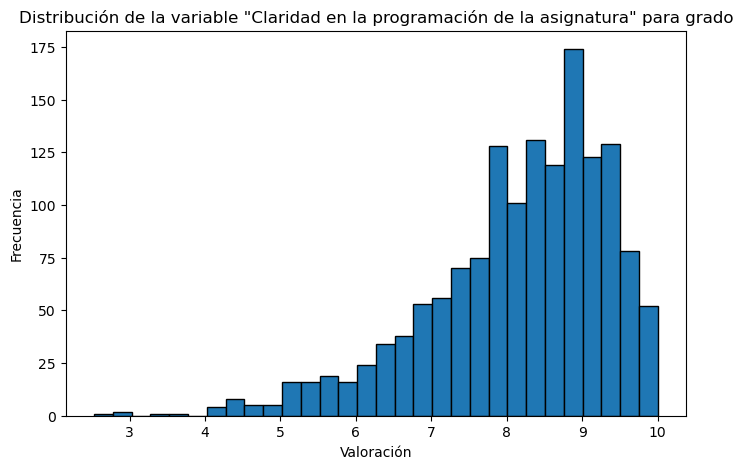

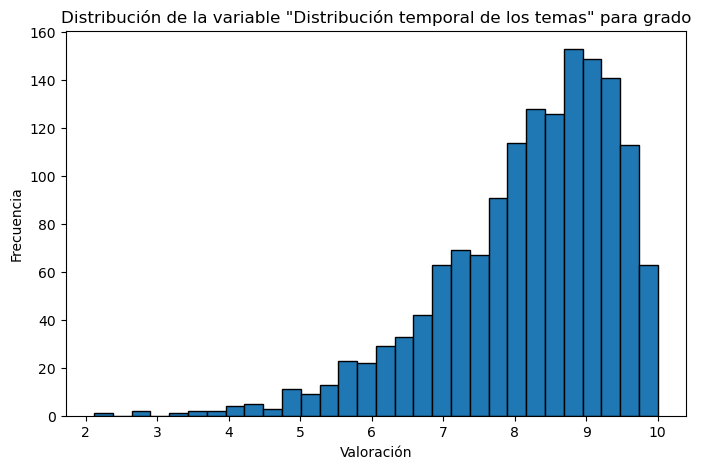

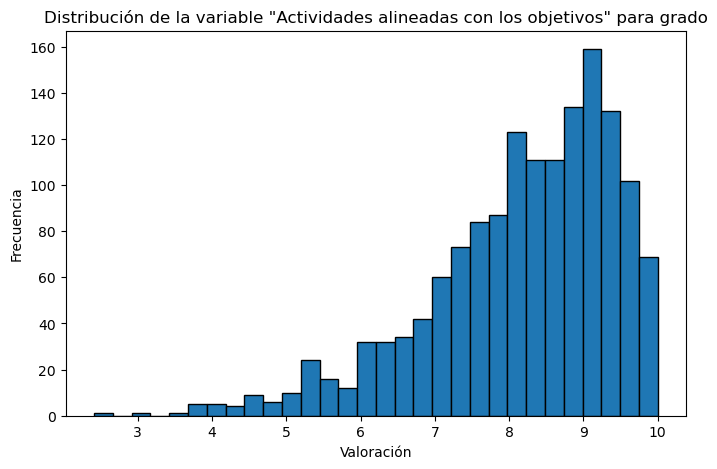

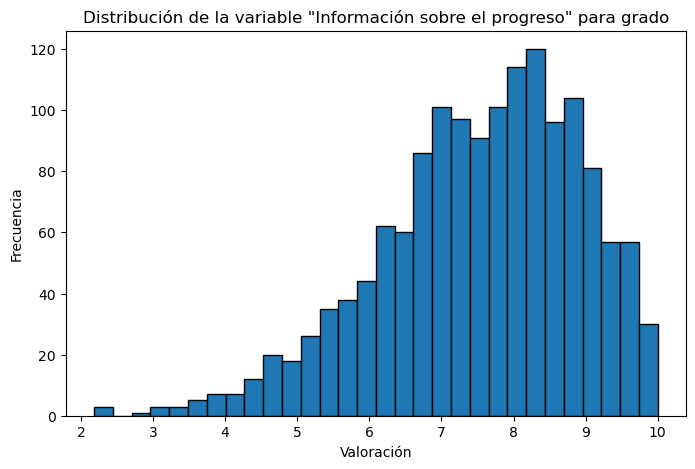

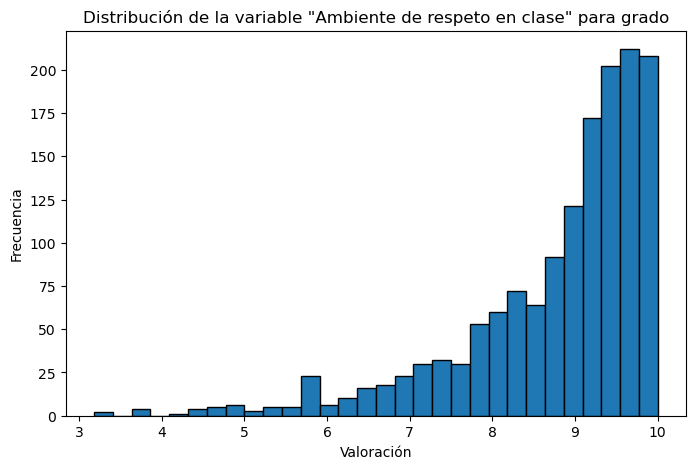

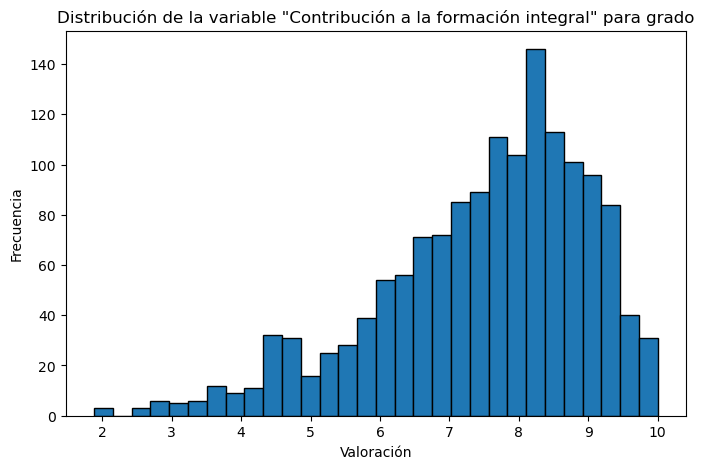

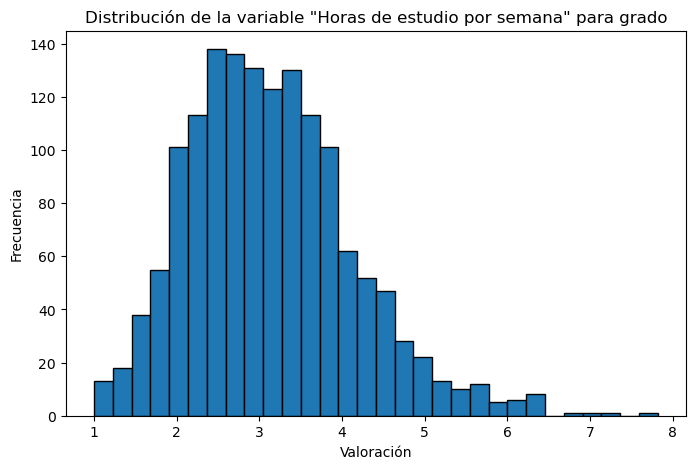

In [29]:
#Gráficos de variables no comunes para grado
graficar_variables_nocomunes(df_grado, continuas=continuas_grado, tipo="grado") 

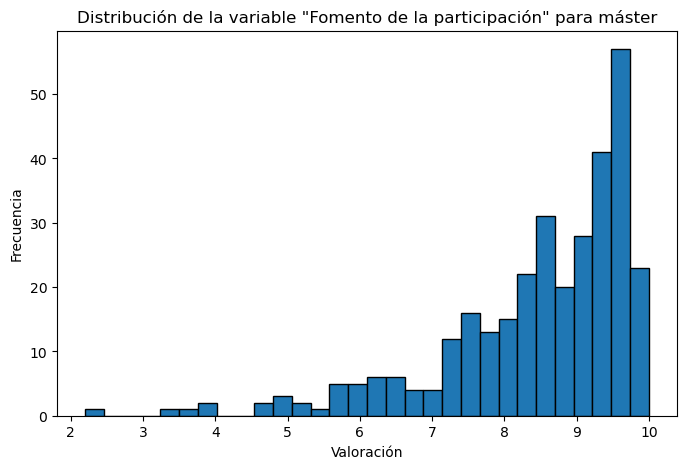

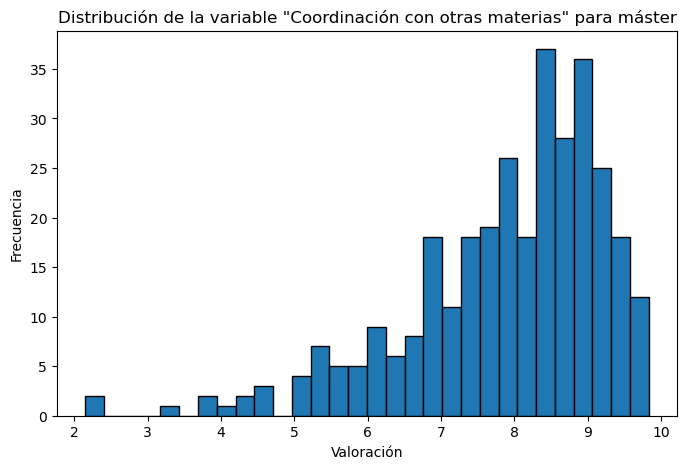

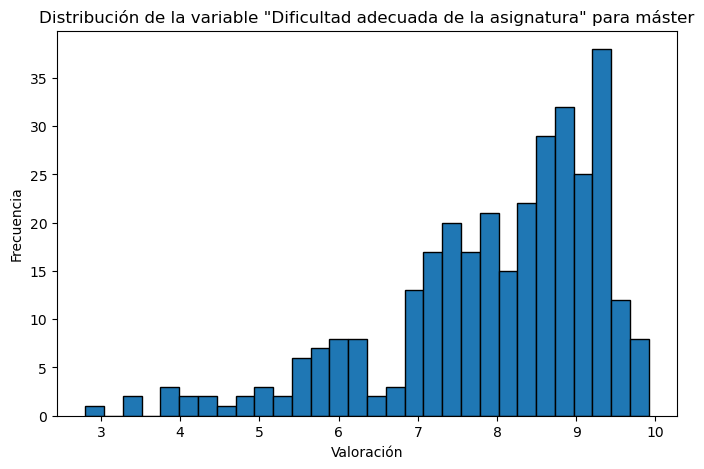

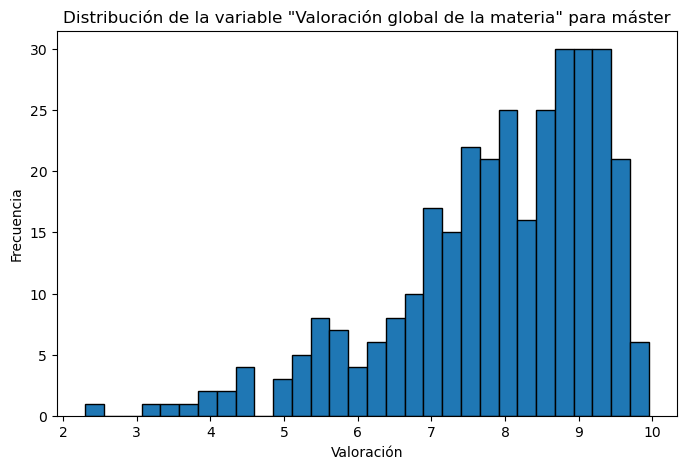

In [30]:
#Gráficos de variables no comunes para máster
graficar_variables_nocomunes(df_master, continuas=continuas_master, tipo="máster")

# ANÁLISIS

## 4. Hacer un análisis de componentes principales usando las preguntas 1-14 en grado y 1-9 en master. (TÉCNICA 1: APRENDIZAJE NO SUPERVISADO).Interpretarlo.

In [512]:
#Variables para PCA de grado: preguntas 1 a 14
df_PCA_grado = df_grado[['asistencia', 'puntualidad', 'dominio_materia',
       'claridad_explicaciones', 'claridad_programacion_asignatura',
       'distribucion_temporal_temas', 'materiales_actualizados',
       'recursos_adecuados', 'actividades_objetivos', 'informacion_progreso',
       'ambiente_respeto', 'accesibilidad', 'formacion_integral',
       'percepcion_aprendizaje']]

#Variables para PCA de máster: preguntas 1 a 9
df_PCA_master = df_master[['puntualidad', 'asistencia', 'dominio_materia',
       'claridad_explicaciones', 'materiales_actualizados',
       'recursos_adecuados', 'fomento_participacion', 'accesibilidad',
       'percepcion_aprendizaje']]

###  Índice KMO

In [514]:
#Grado
kmo_all_grado, kmo_model_grado = calculate_kmo(df_PCA_grado)

#Máster
kmo_all_master, kmo_model_master = calculate_kmo(df_PCA_master)

print(f'''
Índice KMO grado: {kmo_model_grado}
Índice KMO máster: {kmo_model_master}''')


Índice KMO grado: 0.9418838064981845
Índice KMO máster: 0.888755095347688


C:\Users\javie\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Los valores obtenidos son muy buenos. La proporción de la varianza que es debida a factores comunes es muy alta. La correlación total entre las variables es alta.

### Test de esfericidad de Bartlett

In [516]:
#Grado
chi_square_value_grado, p_value_grado = calculate_bartlett_sphericity(df_PCA_grado)

#Máster
chi_square_value_master, p_value_master = calculate_bartlett_sphericity(df_PCA_master)

print(f'''
Grado: {chi_square_value_grado, p_value_grado}
Máster: {chi_square_value_master, p_value_master}''')


Grado: (30412.5668584463, 0.0)
Máster: (3701.0671817698503, 0.0)


El test es estadísticamente significativo, así que las variables están correlacionadas (la matriz de correlación no es igual a la matriz identidad)

### Matriz de correlación

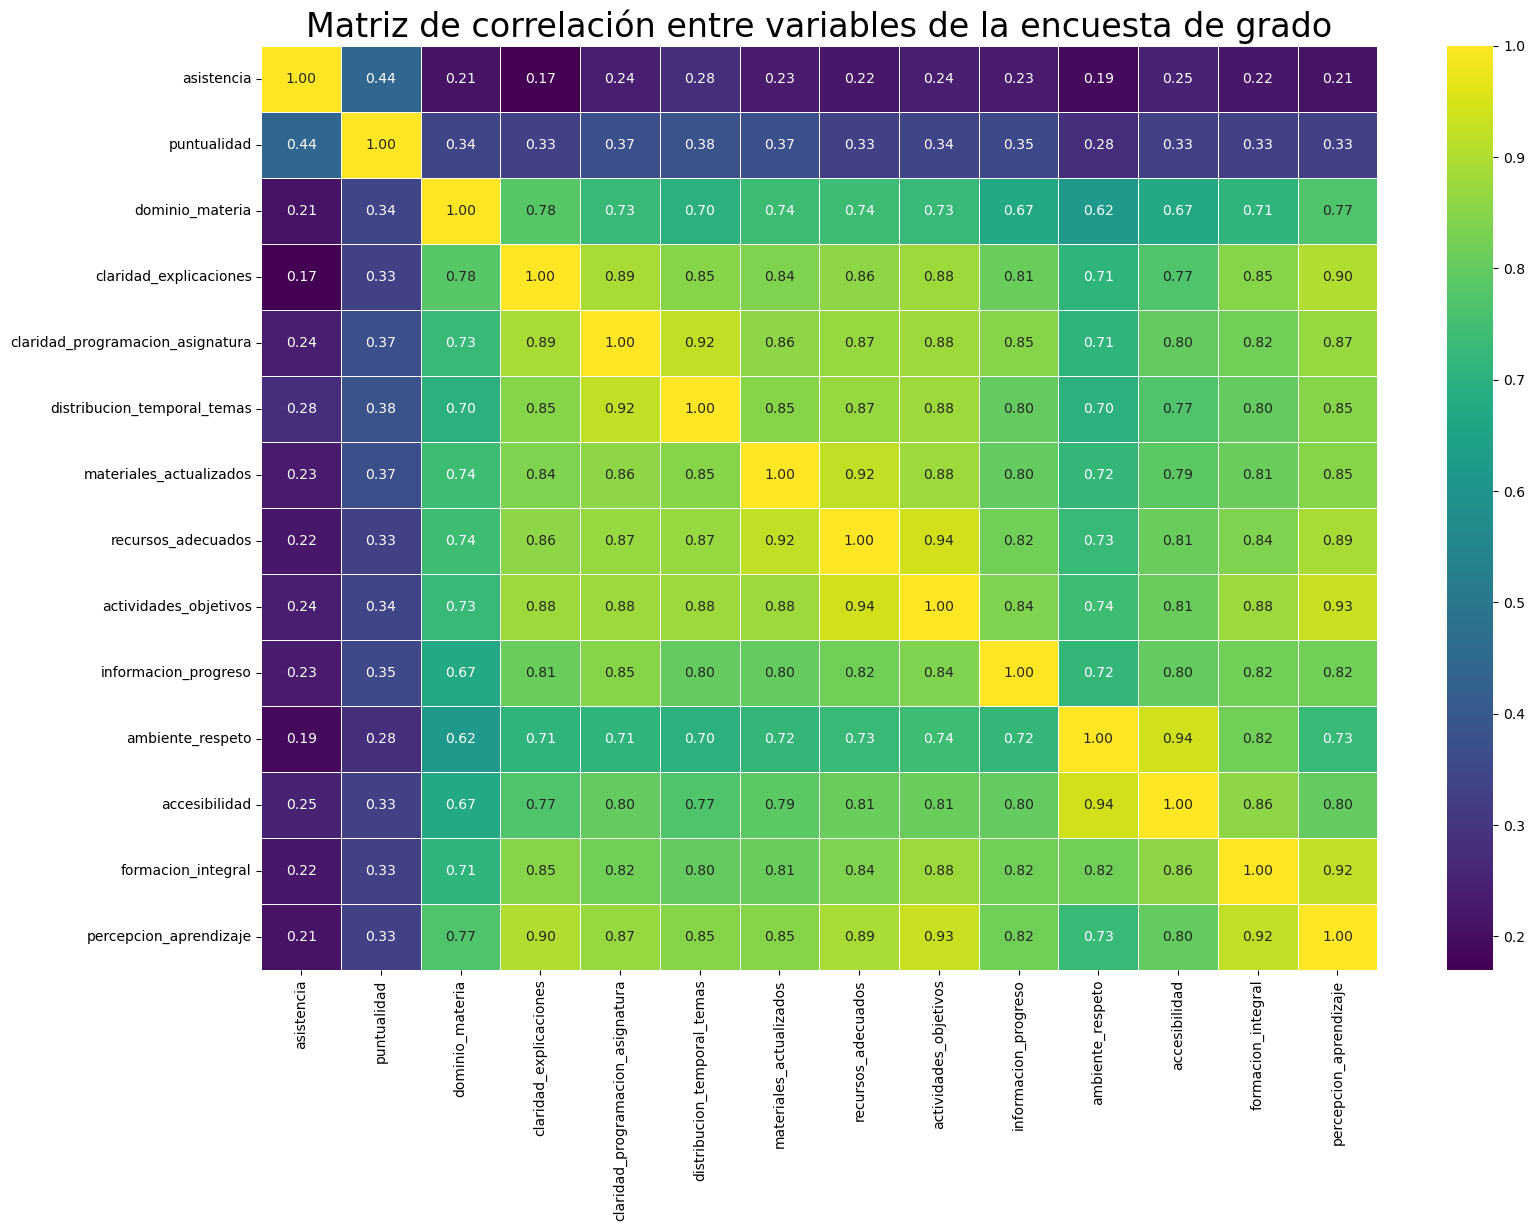

In [520]:
# Calcular la matriz de correlación para grado
mc_grado = df_PCA_grado.corr().round(2)

# Crear mapa de calor e incluir valores del coeficiente de correlación
plt.figure(figsize=(18, 12))
sns.heatmap(mc_grado, annot=True, cmap='viridis', linewidths=0.5, fmt=".2f")
plt.title('Matriz de correlación entre variables de la encuesta de grado', fontsize=24)
plt.savefig("mc_grado.png")
plt.show()


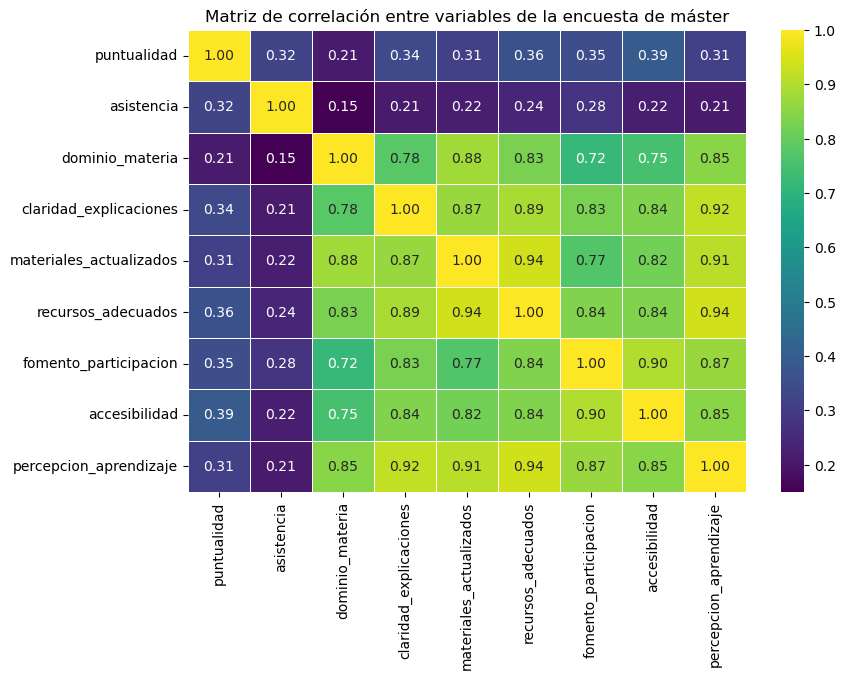

In [525]:
# Calcular la matriz de correlación para máster
mc_master = df_PCA_master.corr().round(2)

# Crear mapa de calor e incluir valores del coeficiente de correlación
plt.figure(figsize=(9, 6))
sns.heatmap(mc_master, annot=True, cmap='viridis', linewidths=0.5, fmt=".2f")
plt.title('Matriz de correlación entre variables de la encuesta de máster', fontsize=12)
plt.savefig("mc_master.png")
plt.show()

### Codificando los PCA

In [522]:
#Desarrollamos los componentes principales
pca_grado = PCA(n_components=14) #Tantos componentes como número de variables
pca_comp_grado = pca_grado.fit_transform(df_PCA_grado)

pca_master = PCA(n_components=9)
pca_comp_master = pca_master.fit_transform(df_PCA_master)

print(f"PCA grado: {pca_comp_grado.shape} \n"
f"PCA máster: {pca_comp_master.shape}")

PCA grado: (1479, 14) 
PCA máster: (321, 9)


### Varianza acumulada

In [524]:
# Obtener el porcentaje de varianza explicada por el PCA para el dataset de grado
PCAnames_grado = ['PC' + str(n_pca + 1) for n_pca in range(pca_grado.n_components)]
exp_variance_grado = pd.DataFrame(data=pca_grado.explained_variance_ratio_, index = PCAnames_grado, columns=['Exp_variance'])
exp_variance_grado['cum_Exp_variance'] = exp_variance_grado['Exp_variance'].cumsum()
exp_variance_grado

,Exp_variance,cum_Exp_variance
PC1,0.800056,0.800056
PC2,0.042140,0.842195
PC3,0.039335,0.881530
PC4,0.024053,0.905584
PC5,0.020416,0.925999
PC6,0.016598,0.942597
PC7,0.014181,0.956779
PC8,0.012296,0.969075
PC9,0.007846,0.976921
PC10,0.006804,0.983725


In [526]:
# Obtener el porcentaje de varianza explicada por el PCA para el dataset de grado
PCAnames_master = ['PC' + str(n_pca + 1) for n_pca in range(pca_master.n_components)]
exp_variance_master = pd.DataFrame(data=pca_master.explained_variance_ratio_, index = PCAnames_master, columns=['Exp_variance'])
exp_variance_master['cum_Exp_variance'] = exp_variance_master['Exp_variance'].cumsum()
exp_variance_master

,Exp_variance,cum_Exp_variance
PC1,0.853587,0.853587
PC2,0.044717,0.898304
PC3,0.025742,0.924046
PC4,0.024284,0.948330
PC5,0.016875,0.965205
PC6,0.011458,0.976663
PC7,0.011288,0.987952
PC8,0.007545,0.995496
PC9,0.004504,1.000000


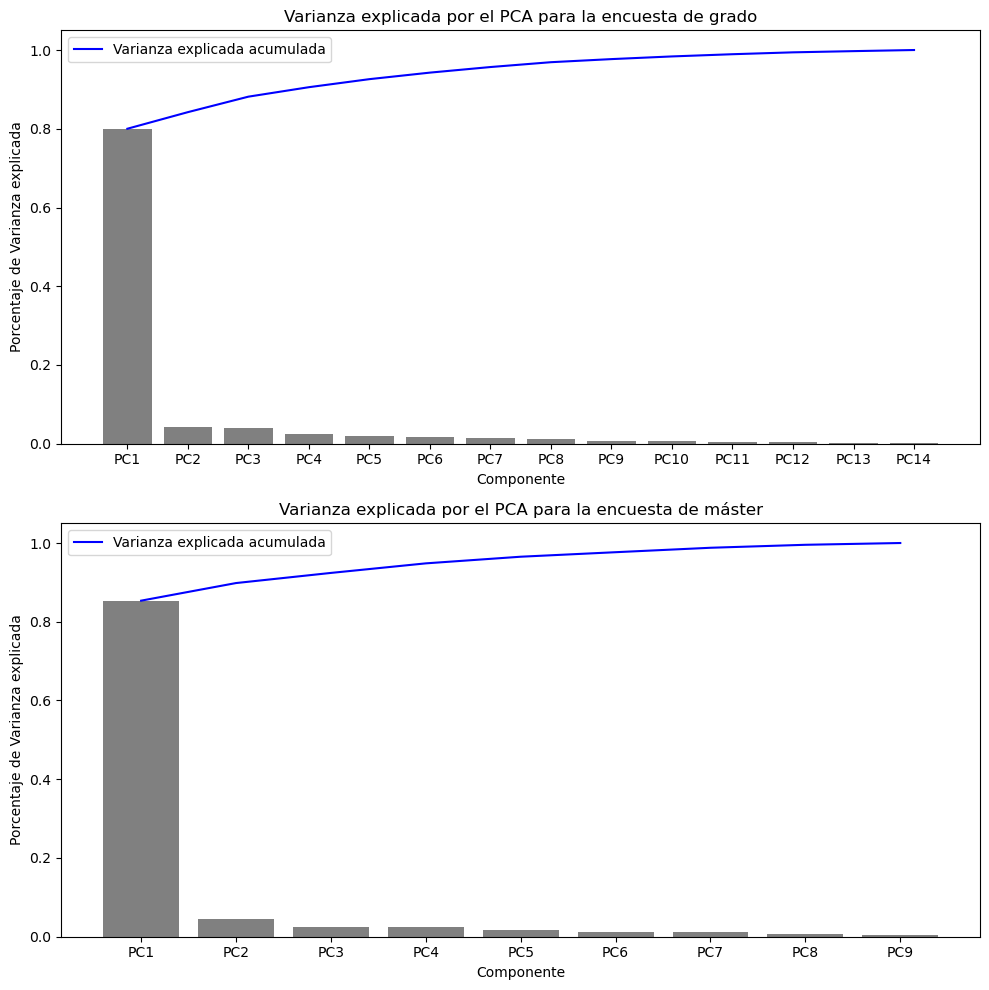

In [497]:
# Crear figura con dos ejes (para los dos gráficos)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Primer gráfico (grado)
sns.barplot(data=exp_variance_grado, x=exp_variance_grado.index, y='Exp_variance', color='gray', ax=ax1)
sns.lineplot(data=exp_variance_grado, x=exp_variance_grado.index, y='cum_Exp_variance', color='blue', label='Varianza explicada acumulada', ax=ax1)
ax1.set_ylabel('Porcentaje de Varianza explicada')
ax1.set_xlabel('Componente')
ax1.legend()
ax1.set_title('Varianza explicada por el PCA para la encuesta de grado')

# Segundo gráfico (máster)
sns.barplot(data=exp_variance_master, x=exp_variance_master.index, y='Exp_variance', color='gray', ax=ax2)
sns.lineplot(data=exp_variance_master, x=exp_variance_master.index, y='cum_Exp_variance', color='blue', label='Varianza explicada acumulada', ax=ax2)
ax2.set_ylabel('Porcentaje de Varianza explicada')
ax2.set_xlabel('Componente')
ax2.legend()
ax2.set_title('Varianza explicada por el PCA para la encuesta de máster')

plt.tight_layout()
plt.savefig("varianzaPCA.png")
plt.show()

### Loadings

In [528]:
# Conseguir los loadings del PCA de grado
loadings_grado = pd.DataFrame(pca_grado.components_.T, columns=PCAnames_grado, index=df_PCA_grado.columns)
loadings_grado

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
asistencia,-0.042988,0.286335,-0.389742,-0.053522,0.018021,-0.660861,-0.371898,0.395113,0.139672,0.069631,0.026965,0.030843,-0.058346,-0.021858
puntualidad,-0.085570,0.569065,-0.607745,-0.223701,0.055496,0.372090,0.244225,-0.207390,0.048746,-0.045667,-0.011090,-0.016275,0.015474,-0.013025
dominio_materia,-0.146019,0.073411,0.041175,-0.159701,-0.098712,0.239071,-0.026197,0.612774,-0.621552,-0.236305,-0.119590,-0.214774,-0.020276,-0.002302
claridad_explicaciones,-0.310905,0.095892,0.231112,-0.125522,-0.021343,0.434263,-0.364951,0.290689,0.554565,0.193098,-0.236871,0.054344,0.086677,0.082712
claridad_programacion_asignatura,-0.285935,0.198382,0.102887,0.281859,-0.122276,0.125364,-0.315308,-0.152102,-0.043869,0.011201,0.675336,-0.370189,-0.189697,-0.066929
distribucion_temporal_temas,-0.285455,0.248499,0.080350,0.256627,-0.329562,-0.104834,-0.326378,-0.414979,-0.313364,-0.072871,-0.467203,0.232716,0.095560,-0.032306
materiales_actualizados,-0.232286,0.109675,0.058665,0.110351,-0.261256,-0.052347,0.392439,0.172077,-0.146393,0.574470,0.160504,0.342691,-0.159214,0.379194
recursos_adecuados,-0.270178,0.087424,0.135641,0.071999,-0.220244,-0.185863,0.444119,0.104203,0.174716,0.117841,-0.111893,-0.260030,0.187581,-0.667002
actividades_objetivos,-0.305899,0.074589,0.155126,-0.044889,-0.037893,-0.265003,0.289122,-0.075775,0.243764,-0.441100,-0.161656,-0.352018,-0.171736,0.529391
informacion_progreso,-0.317048,0.016759,-0.052834,0.543482,0.734230,0.037293,0.103098,0.120069,-0.063565,-0.037103,-0.103623,0.126738,-0.028054,-0.050007


In [530]:
# Conseguir los loadings del PCA de máster
loadings_master = pd.DataFrame(pca_master.components_.T, columns=PCAnames_master, index=df_PCA_master.columns)
loadings_master

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
puntualidad,-0.063876,-0.236382,-0.482218,-0.705768,-0.040098,-0.019932,0.430745,0.128517,-0.073062
asistencia,-0.031090,-0.114537,-0.103412,-0.275035,-0.313521,-0.582715,-0.564700,-0.365605,0.095769
dominio_materia,-0.234481,0.307747,0.421873,-0.140379,0.224457,-0.588627,0.374789,0.155662,0.301774
claridad_explicaciones,-0.450007,0.112740,-0.670968,0.421967,0.247288,-0.221545,-0.092334,0.178868,0.075999
materiales_actualizados,-0.330843,0.366088,0.153071,-0.309730,0.174209,0.065435,-0.336802,0.193650,-0.672007
recursos_adecuados,-0.379211,0.201536,0.050701,-0.251295,-0.259251,0.448877,-0.268834,0.222918,0.599330
fomento_participacion,-0.379523,-0.636743,0.273963,0.189857,-0.338237,-0.123675,0.019169,0.423859,-0.172324
accesibilidad,-0.338403,-0.452850,0.165243,-0.123182,0.635329,0.176864,-0.101379,-0.420584,0.125853
percepcion_aprendizaje,-0.475029,0.196046,0.015313,0.134847,-0.415883,0.110155,0.387592,-0.591483,-0.179785


C:\Users\javie\AppData\Local\Temp\ipykernel_98236\78219791.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\javie\AppData\Local\Temp\ipykernel_98236\78219791.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


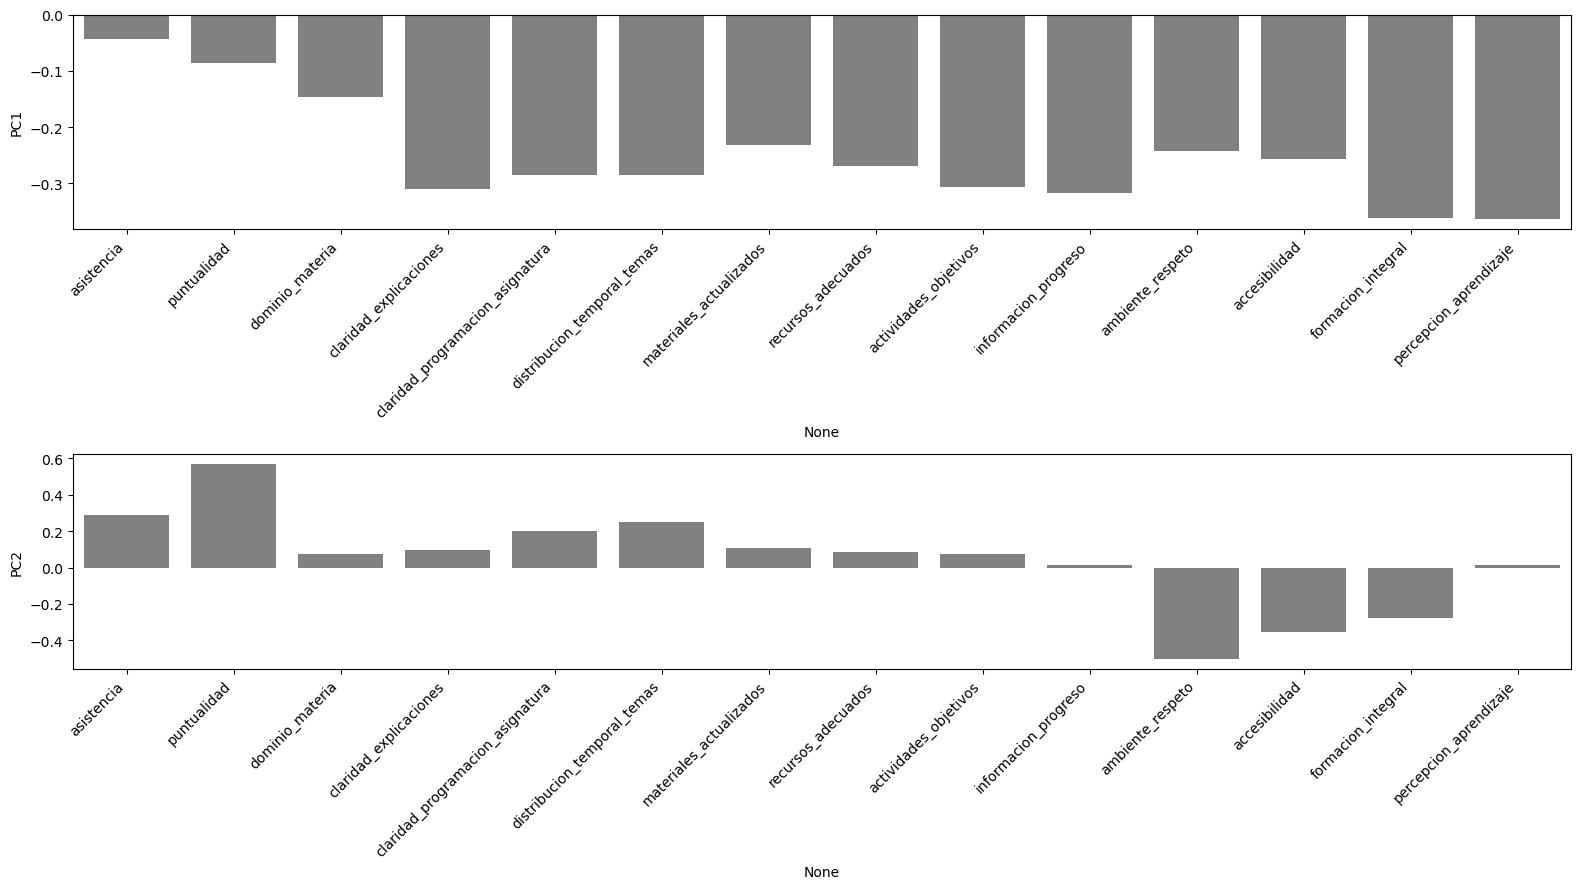

In [532]:
# Hacer un gráfico de los valores de los loadings en grado
fig, axes = plt.subplots(2, 1, figsize=(16, 9))  # para los 2 primeros componentes
PC = 0
for ax in axes.ravel():
    sns.barplot(data=loadings_grado, x=loadings_grado.index, y=loadings_grado.columns[PC], color='gray', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    PC += 1

plt.tight_layout()  # ajusta márgenes automáticamente
plt.savefig("loadings_grado.png")
plt.show()

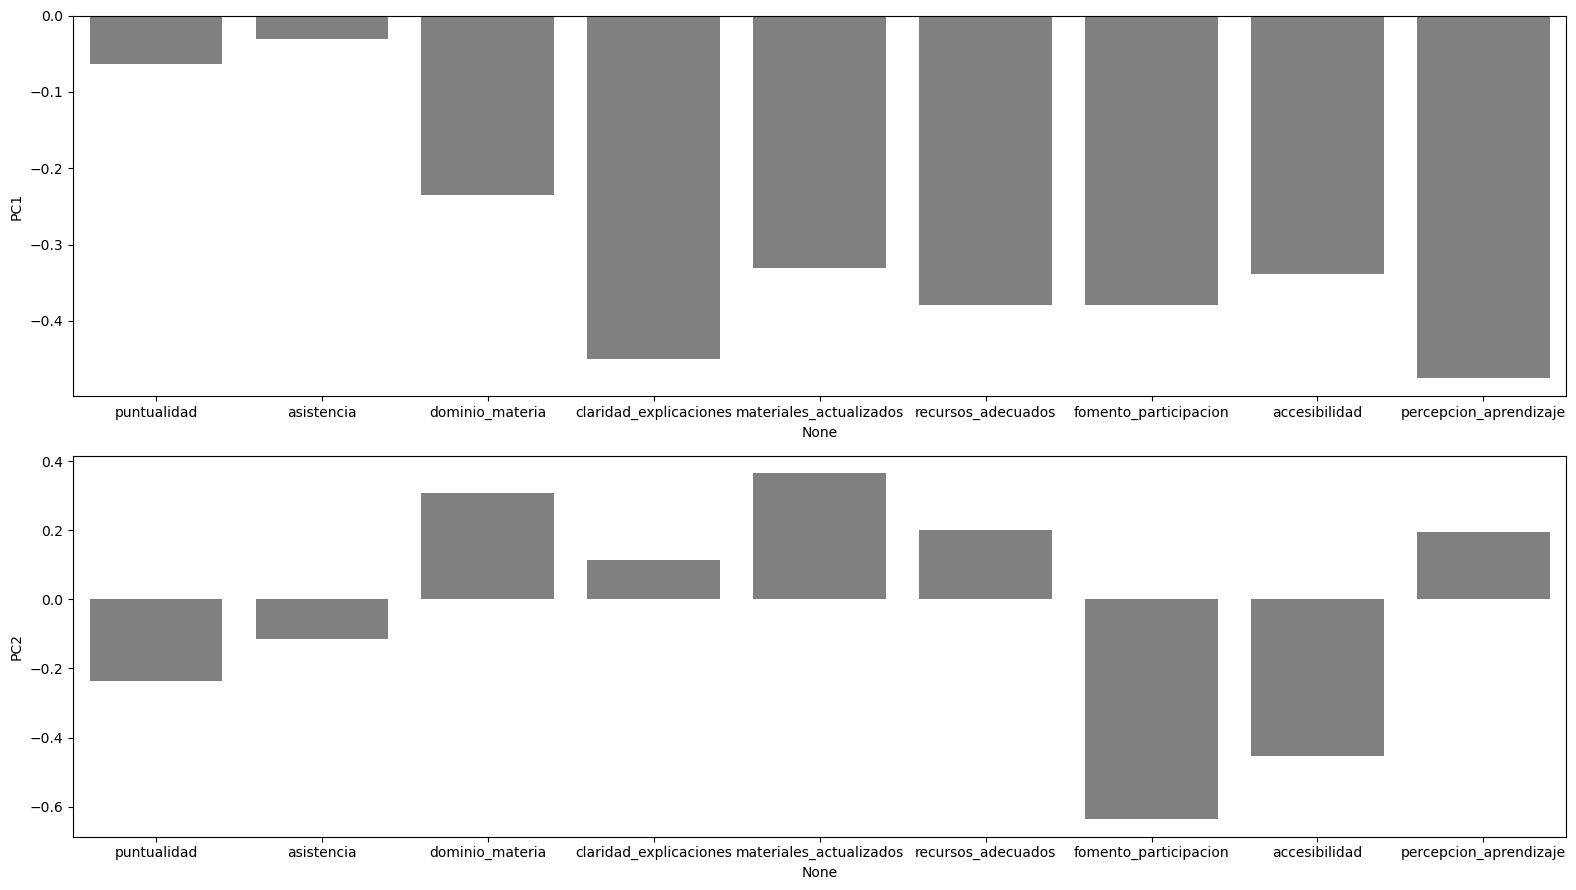

In [501]:
# Hacer un gráfico de los valores de los loadings en máster
fig, axes = plt.subplots(2, 1, figsize=(16, 9))  # para los 2 primeros componentes
PC = 0
for ax in axes.ravel():
    sns.barplot(data=loadings_master, x=loadings_master.index, y=loadings_master.columns[PC], color='gray', ax=ax)
    PC += 1

plt.tight_layout()
plt.savefig("loadings_máster.png")
plt.show()

Se observa que la mayor parte de la varianza es explicada por el primer componente (en más de un 80%, tanto en grado como en máster). Igualmente, para ambos casos, los loadings del primer componente tienen más o menos el mismo valor, exceptuando la valoración de la puntualidad, la asistencia a clase y puede que el dominio de la materia. Como la gran mayoría de la variabilidad se puede explicar por la mayoría de las variables en similar medida, se puede suponer que están altamente correlacionadas.

## 5. Hacer un análisis clúster (jerárquico) usando las preguntas 1-14 en grado y 1-9 en master. (TÉCNICA 2: APRENDIZAJE NO SUPERVISADO).Ver la composición de cada clúster según el resto de variables e interpretarlos.

### Dendrograma

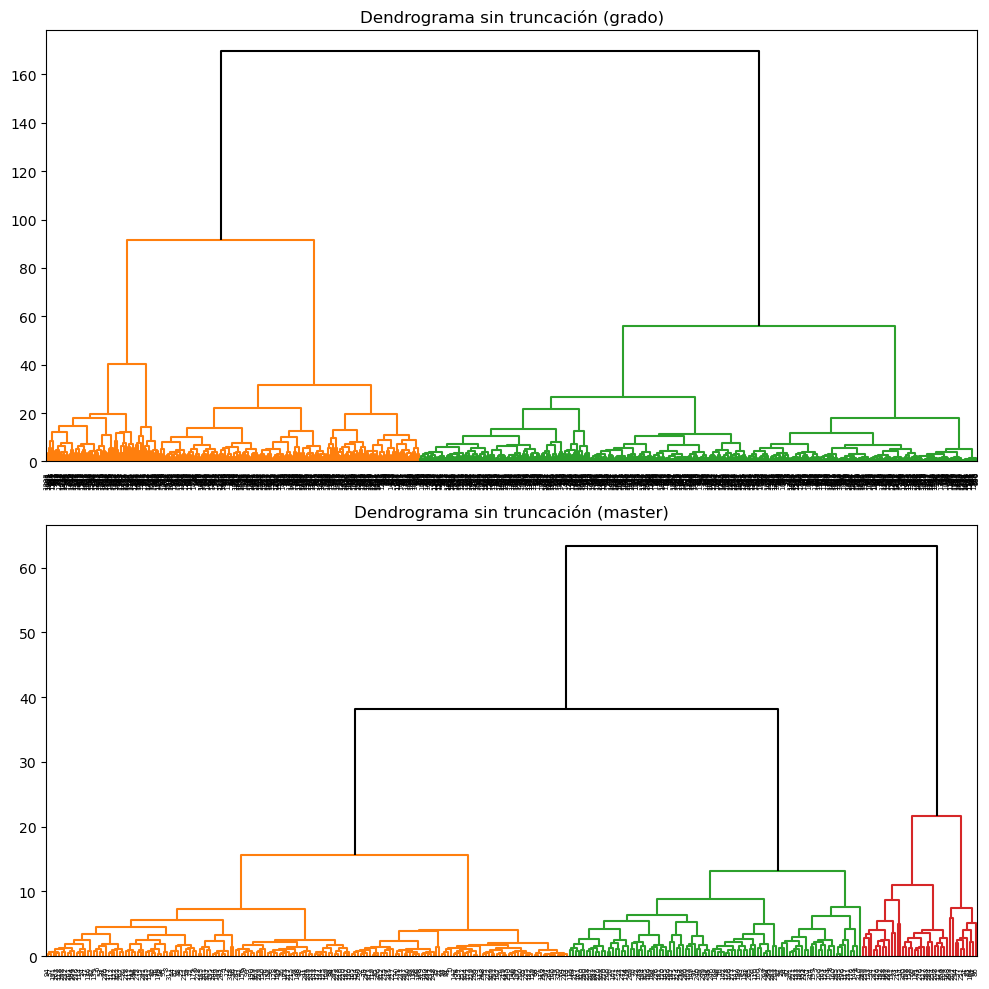

In [534]:
# Crear figura con dos ejes (para los dos gráficos)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# === PRIMER GRÁFICO: Dendrograma para Grado ===
linked_grado = linkage(df_PCA_grado, method='ward') #'ward' agrupa minimizando la varianza intra-clúster

dendrogram(
    linked_grado, # Matriz de enlace generada por linkage()
    orientation='top',  # El árbol se dibuja de arriba hacia abajo
    truncate_mode='none', #sin truncar
    above_threshold_color='k', # Las ramas por encima del umbral se dibujan en negro
    color_threshold=100, # Umbral de distancia para diferenciar con colores los clústers
    distance_sort='descending', # Ordena las fusiones por distancia descendente
    ax=ax1
)

ax1.set_title('Dendrograma sin truncación (grado)')

# === SEGUNDO GRÁFICO: Dendrograma para Máster ===
linked_master = linkage(df_PCA_master, method='ward')

dendrogram(
    linked_master,
    orientation='top',
    truncate_mode='none',
    above_threshold_color='k',
    color_threshold=30,
    distance_sort='descending',
    ax=ax2
)

ax2.set_title('Dendrograma sin truncación (master)')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

### Métricas


In [921]:
def ch_index(df,tipo):
    # Rango de clústeres a evaluar
    range_n_clusters = list(range(2, 11))
    ch_scores = []
    
    for k in range_n_clusters:
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(df)
        ch_score = calinski_harabasz_score(df, labels)
        ch_scores.append(ch_score)

    # Encontrar número óptimo
    optimal_k = range_n_clusters[np.argmax(ch_scores)]
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(range_n_clusters, ch_scores, marker='o')
    plt.axvline(x=optimal_k, color='red', linestyle='--')
    plt.title(f"Número optimo de clústeres ({tipo})")
    plt.xlabel("Número de clústers")
    plt.ylabel("Índice CH")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

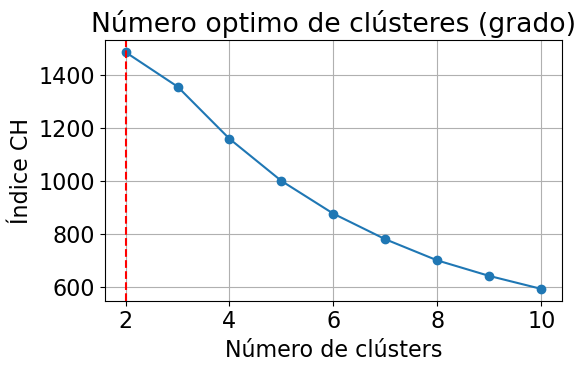

In [923]:
#Grado
ch_index(df=df_PCA_grado,tipo="grado")

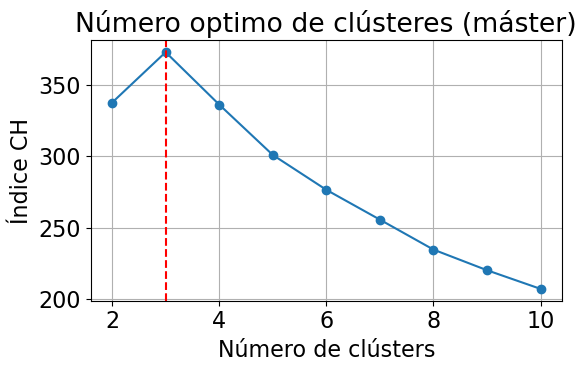

In [925]:
#Máster
ch_index(df=df_PCA_master,tipo="máster")

### Clústers en el PCA

In [762]:
# Cortar el dendrograma por el número de clústers

cluster_nclust_grado = cut_tree(linked_grado, n_clusters=[2])
cluster_nclust_master = cut_tree(linked_master, n_clusters=[3])

In [764]:
#Clasificar los datos según los clústers

df_grado_cluster = df_PCA_grado.copy()
df_grado_cluster["cluster"] = cluster_nclust_grado

df_master_cluster = df_PCA_master.copy()
df_master_cluster["cluster"] = cluster_nclust_master

In [766]:
#Calcular porcentaje de elementos en cada clúster

porc_cluster_grado = [
    (len(df_grado_cluster[df_grado_cluster["cluster"] == 0].index)/len(df_grado_cluster.index))*100, 
    (len(df_grado_cluster[df_grado_cluster["cluster"] == 1].index)/len(df_grado_cluster.index))*100
]

porc_cluster_master = [
    (len(df_master_cluster[df_master_cluster["cluster"] == 0].index)/len(df_master_cluster.index))*100, 
    (len(df_master_cluster[df_master_cluster["cluster"] == 1].index)/len(df_master_cluster.index))*100,
    (len(df_master_cluster[df_master_cluster["cluster"] == 2].index)/len(df_master_cluster.index))*100
]

In [768]:
#Clasificar en función del componente principal y el clustering

#Grado
PCA_cluster_grado = pd.DataFrame(pca_comp_grado[:, :1], columns=['PC1'])
PCA_cluster_grado['cluster'] = cluster_nclust_grado
PCA_cluster_grado['juicio_global'] = df_grado['juicio_global'].values

#Máster
PCA_cluster_master = pd.DataFrame(pca_comp_master[:, :1], columns=['PC1'])
PCA_cluster_master['cluster'] = cluster_nclust_master
PCA_cluster_master['juicio_global'] = df_master['juicio_global'].values

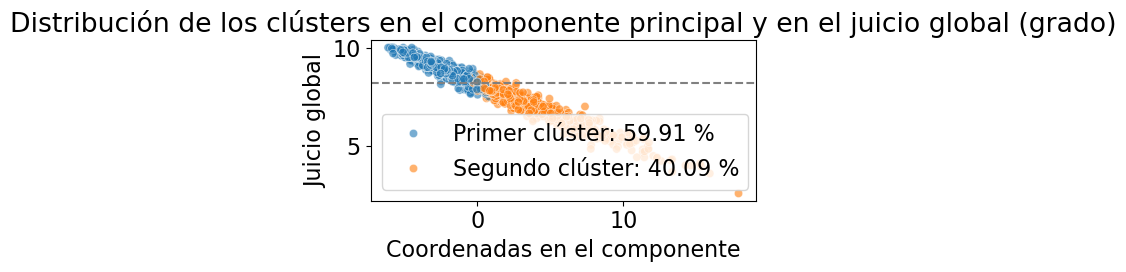

In [776]:
#Representación para grado

media_juicio_grado = PCA_cluster_grado['juicio_global'].mean()

plt.figure(figsize=(5, 3))
ax = sns.scatterplot(
    data=PCA_cluster_grado,
    x='PC1',
    y='juicio_global',
    hue='cluster',
    alpha=0.6
)

plt.title('Distribución de los clústers en el componente principal y en el juicio global (grado)')
plt.xlabel('Coordenadas en el componente')
plt.ylabel('Juicio global')

#Línea horizontal de media de juicio global
plt.axhline(y=media_juicio_grado, color='gray', linestyle='--')

# Obtener los handles y labels del gráfico original
handles, _ = ax.get_legend_handles_labels()

# Asignar nuevas etiquetas conservando los colores
custom_labels = [
    f"Primer clúster: {porc_cluster_grado[0]:.2f} %",
    f"Segundo clúster: {porc_cluster_grado[1]:.2f} %"
]
plt.legend(handles=handles, labels=custom_labels)

plt.tight_layout()
plt.show()

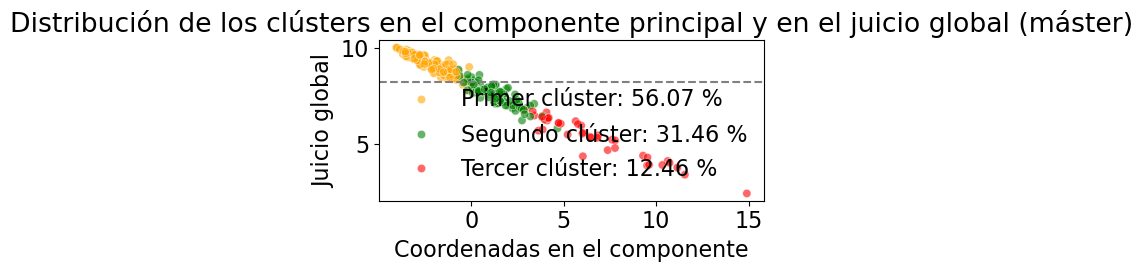

In [783]:
#Representación para máster

media_juicio_master = PCA_cluster_master['juicio_global'].mean()

plt.figure(figsize=(5, 3))
ax = sns.scatterplot(
    data=PCA_cluster_master,
    x='PC1',
    y='juicio_global',
    hue='cluster',
    alpha=0.6,
    palette= cluster_colors
)


plt.title('Distribución de los clústers en el componente principal y en el juicio global (máster)')
plt.xlabel('Coordenadas en el componente')
plt.ylabel('Juicio global')

#Línea horizontal de media de juicio global
plt.axhline(y=media_juicio_grado, color='gray', linestyle='--')

# Obtener los handles y labels del gráfico original
handles, _ = ax.get_legend_handles_labels()

# Asignar nuevas etiquetas conservando los colores
custom_labels = [
    f"Primer clúster: {porc_cluster_master[0]:.2f} %",
    f"Segundo clúster: {porc_cluster_master[1]:.2f} %",
    f"Tercer clúster: {porc_cluster_master[2]:.2f} %"
]
plt.legend(handles=handles, labels=custom_labels, loc='lower left', framealpha=0)

plt.tight_layout()
plt.show()

### Explicar clúster en función de otras variables 

In [939]:
#Clasificar en función del cluster

cluster_grado = df_grado.copy()
cluster_grado['cluster'] = cluster_nclust_grado

cluster_master = df_master.copy()
cluster_master['cluster'] = cluster_nclust_master

In [387]:
variables_cluster = {
'Nacionalidad_espanol':"Nacionalidad",
"Profesor_Mujer":"Sexo",
"Idioma_Espanol":"Idioma", 'dedicacionProfesor':'Dedicación',
'Porcentaje_notables': 'Porcentaje notables',
'numeroAlumnos': 'Nº de alumnos',
'notaMedia': 'Nota media',
'cuatrimestre': 'Cuatrimestre'
}

In [941]:
#Renombrar valores en las variables
for df in [cluster_grado, cluster_master]:
    df["Nacionalidad_espanol"] = df["Nacionalidad_espanol"].replace({1:"Español", 0:"No español"})
    df["Profesor_Mujer"] = df["Profesor_Mujer"].replace({1:"Mujer", 0:"Hombre"})
    df["Idioma_Espanol"] = df["Idioma_Espanol"].replace({1:"Español", 0:"No español"})
    df.rename(columns=variables_cluster, inplace=True)
    df['Nota media'] = df['Nota media'] * 10
    df['Porcentaje suspensos'] = df['Porcentaje_suspensos'] * 100
    df['Curso'] = df["Curso"].replace({1:"1º", 2:"2º", 3:"3ª", 4:"4º", 5:"5º"})
    df['cluster'] = df['cluster'].replace({0:"1º", 1:"2º",2:"3º"})

In [943]:
variables_num = [
    #Variables de grupo numéricas
    'Porcentaje suspensos', 'Nº de alumnos', 'Nota media']

In [787]:
cluster_colors = ['orange','green','red']

In [945]:
def generate_strong_gradient(base_color, n):
    base_hsv = mcolors.rgb_to_hsv(to_rgb(base_color))
    return [
        mcolors.to_hex(mcolors.hsv_to_rgb([
            base_hsv[0],
            min(1.0, base_hsv[1] * (1 + 0.3 * (i / max(1, n - 1)))),
            max(0.4, base_hsv[2] * (0.7 + 0.3 * (i / max(1, n - 1))))
        ]))
        for i in range(n)
    ]

# Gráfico con degradado llamativo
def graf_cat(df, variables_cat, tipo):
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_height = 0.8
    df[variables_cat] = df[variables_cat].astype(str)

    y_pos = 0
    group_positions = []
    group_labels = []

    unique_clusters = sorted(df['cluster'].unique())
    cluster_color_map = {cluster: cluster_colors[i % len(cluster_colors)] for i, cluster in enumerate(unique_clusters)}

    for var in variables_cat:
        ct = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
        clusters = ct.index
        clases = ct.columns

        cluster_positions = []
        for cluster in clusters:
            left = 0
            base_color = cluster_color_map[cluster]
            gradient_colors = generate_strong_gradient(base_color, len(clases))

            for i, cls in enumerate(clases):
                val = ct.loc[cluster, cls]
                color = gradient_colors[i]
                ax.barh(y_pos, val, bar_height, left=left, color=color, edgecolor='white')
                if val > 5:
                    ax.text(left + val / 2, y_pos, f'{cls}: {val:.1f}%', va='center', ha='center', fontsize=10, color='black')
                left += val
            cluster_positions.append(y_pos)
            y_pos += 1

        group_center = np.mean(cluster_positions)
        group_positions.append(group_center)
        group_labels.append(var)
        y_pos += 0.5

    ax.set_yticks([])
    ax.set_xlabel('Porcentaje (%)')
    ax.set_title(f'Distribución de las variables categóricas sociodemográficas y de grupo ({tipo})')

    for label, pos in zip(group_labels, group_positions):
        ax.text(-5, pos, label, va='center', ha='right', fontsize=10, fontweight='bold')

    leyenda_colores = [cluster_color_map[cl] for cl in unique_clusters]
    leyenda_labels = [str(cl) for cl in unique_clusters]

    ax.legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in leyenda_colores],
              leyenda_labels,
              title='Clúster', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [903]:
def graf_num(df,tipo):
    # Calcular medias
    media_df = (
        df.groupby('cluster')[variables_num]
        .mean()
        .reset_index()
        .melt(id_vars='cluster', var_name='variable', value_name='media')
    )

    etiquetas = media_df['variable'].unique()
    clusters = sorted(media_df['cluster'].unique())
    colores = ['orange', 'green', 'red'][:len(clusters)]
    ancho = 0.8 / len(clusters)
    y_pos = np.arange(len(etiquetas))

    # Tamaño optimizado del gráfico
    fig_width = 8
    fig_height = max(2.5, len(etiquetas) * 0.75)  # más altura por variable
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=100)

    for i, cluster in enumerate(clusters):
        subset = media_df[media_df['cluster'] == cluster]
        valores = subset['media'].values
        desplazamiento = (i - (len(clusters) - 1) / 2) * ancho
        ax.barh(y_pos + desplazamiento, valores, height=ancho, color=colores[i],
                edgecolor='black',label=cluster)

    # Estética
    ax.set_yticks(y_pos)
    ax.set_yticklabels(etiquetas, fontsize=10)
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_xlabel("Media", fontsize=11)
    ax.set_ylabel("Variables", fontsize=11)
    ax.set_title(f"Medias de las variables numéricas de grupo en los clústers ({tipo})", fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.4)

    # Leyenda fuera del gráfico
    ax.legend(title='Clúster', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9, title_fontsize=10)

    plt.subplots_adjust(right=0.75)  # espacio para leyenda
    plt.show()

#### Gráficos grado

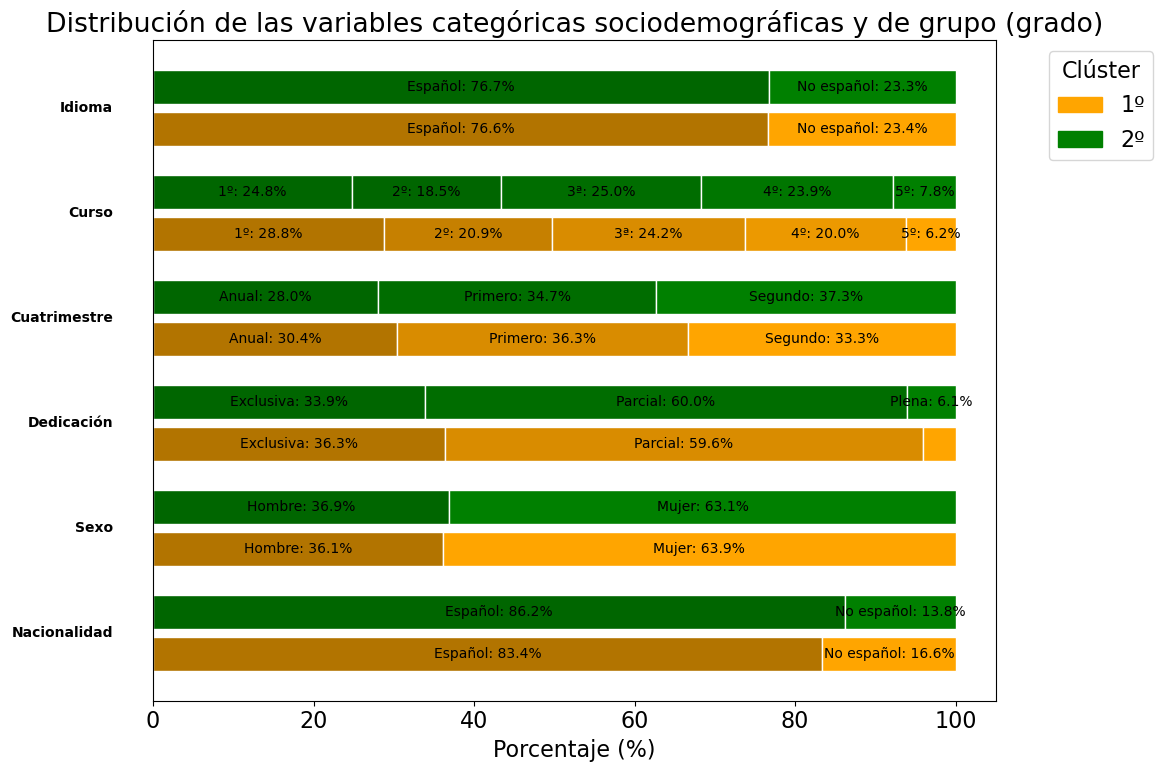

In [947]:
graf_cat(df=cluster_grado,variables_cat = ['Nacionalidad', 'Sexo','Dedicación', 'Cuatrimestre', 'Curso', 'Idioma'], tipo="grado")

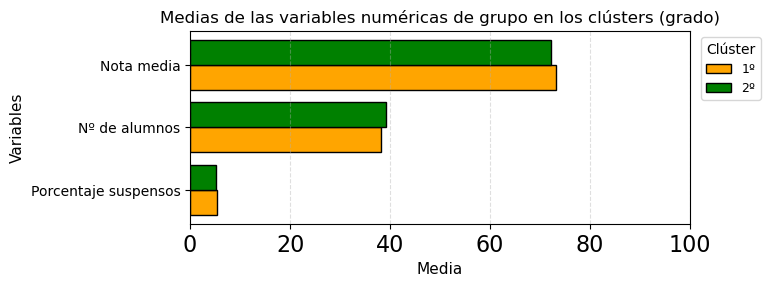

In [949]:
graf_num(df=cluster_grado,tipo="grado")

#### Gráficos master

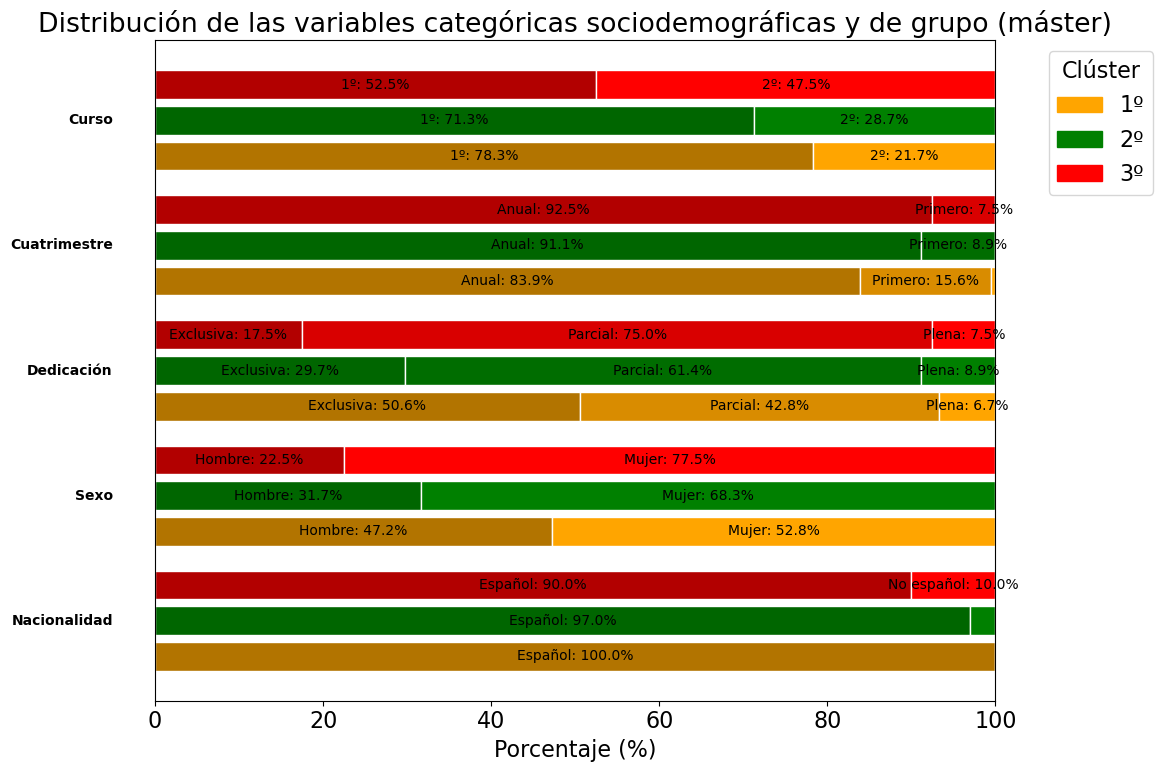

In [915]:
graf_cat(df=cluster_master,variables_cat = ['Nacionalidad', 'Sexo','Dedicación', 'Cuatrimestre', 'Curso'], tipo="máster")

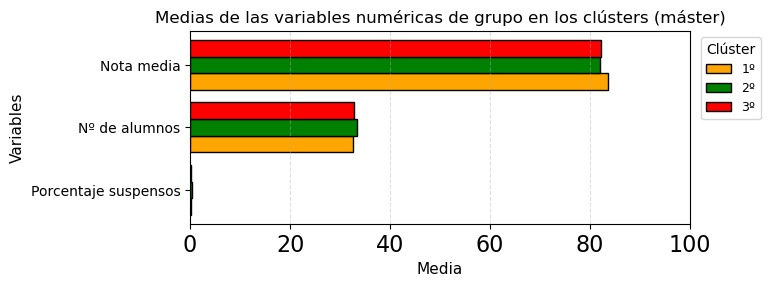

In [951]:
graf_num(df=cluster_master, tipo='máster')

## 6. Modelos explicativos

### Procesos previos

In [17]:
variables_modelo = [ #Definir variables para la regresión
    'juicio_global',
    #Variables sociodemográficas
    'Nacionalidad_espanol', 'Profesor_Mujer', 'Idioma_Espanol', 
     'dedicacionProfesor',
    #Variables de grupo
    'notaMedia', 'Porcentaje_suspensos',
    'numeroAlumnos','formatoEvaluacion', 'porcentajeRespuesta']

def df_modelaje(df):
    df_modelo = df[variables_modelo]
    df_modelo = pd.get_dummies(data=df_modelo, columns=['dedicacionProfesor'], dtype=int, drop_first=False)
    df_modelo = df_modelo.drop(columns=["dedicacionProfesor_Parcial", "dedicacionProfesor_Plena"])
    return df_modelo

df_grado_modelo = df_modelaje(df_grado)
df_master_modelo = df_modelaje(df_master)

In [19]:
#Test de Breusch-Pagan
def breuschpagan(model):
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    test = sms.het_breuschpagan(model.resid, model.model.exog)
    return lzip(names, test)

In [21]:
#Cálculo de factores de inflación de la varianza (multicolinealidad)
def vif(df,variables_ind):
    vif_data = pd.DataFrame()
    vif_data["feature"] = variables_ind
    
    vif_data["VIF"] = [variance_inflation_factor(df[variables_ind].values, i)
                              for i in range(len(variables_ind))]
    return vif_data

In [23]:
vif_grado = vif(df=df_grado_modelo, variables_ind= ['Profesor_Mujer', 'Idioma_Espanol',
                                     'dedicacionProfesor_Exclusiva','notaMedia',
                                     'formatoEvaluacion','Porcentaje_suspensos'])
print(vif_grado)

                        feature       VIF
0                Profesor_Mujer  2.718116
1                Idioma_Espanol  4.345905
2  dedicacionProfesor_Exclusiva  1.642701
3                     notaMedia  9.528808
4             formatoEvaluacion  5.661021
5          Porcentaje_suspensos  1.646997


In [25]:
vif_master = vif(df_master_modelo,['Profesor_Mujer',
       'notaMedia',
       'formatoEvaluacion',
       'dedicacionProfesor_Exclusiva', 'Porcentaje_suspensos'])
print(vif_master)

                        feature       VIF
0                Profesor_Mujer  2.596695
1                     notaMedia  4.139365
2             formatoEvaluacion  1.622873
3  dedicacionProfesor_Exclusiva  1.829404
4          Porcentaje_suspensos  1.099201


#### Dicotomización variable juicio global: por encima y por debajo de la media

In [27]:
media_juicio_grado = df_grado["juicio_global"].mean()
media_juicio_master = df_master["juicio_global"].mean()

df_grado["encima_media"] = np.where(df_grado["juicio_global"] > media_juicio_grado, 1, 0)
df_master["encima_media"] = np.where(df_master["juicio_global"] > media_juicio_master, 1, 0)

df_grado_modelo["encima_media"] = df_grado["encima_media"]
df_master_modelo["encima_media"] = df_master["encima_media"]

### 8.	Regresión entre valoración global del profesor y las variables independientes sociodemográficas y de grupo (TÉCNICA 3: APRENDIZAJE SUPERVISADO). No hacer partición train/test (modelos explicativos)

#### Grado

In [29]:
regresion_grado = smf.ols('''juicio_global ~ scale(Profesor_Mujer) + scale(Idioma_Espanol) + 
scale(notaMedia) + scale(Porcentaje_suspensos) + 
scale(formatoEvaluacion) + scale(dedicacionProfesor_Exclusiva)''', data=df_grado_modelo).fit()

regresion_grado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          juicio_global   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.948
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           0.000637
Time:                        11:40:31   Log-Likelihood:                -2377.8
No. Observations:                1479   AIC:                             4770.
Df Residuals:                    1472   BIC:                             4807.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               8.1941      0.031    260.293      0.000       8.132       8.256
scale(Profesor_Mujer)                  -0.0413      0.032     -1.310      0.190      -0.103       0.021
scale(Idioma_Espanol)                   0.0661      0.032      2.072      0.038       0.004       0.129
scale(notaMedia)                        0.1705      0.048      3.547      0.000       0.076       0.265
scale(Porcentaje_suspensos)             0.1516      0.048      3.174      0.002       0.058       0.245
scale(formatoEvaluacion)                0.0171      0.032      0.543      0.587      -0.045       0.079
scale(dedicacionProfesor_Exclusiva)     0.0526      0.033      1.600      0.110      -0.012       0.117
==============================================================================
Omnibus:                      193.876   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.358
Skew:                          -0.976   Prob(JB):                     9.76e-61
Kurtosis:                       3.821   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
breuschpagan(regresion_grado)

[('Lagrange multiplier statistic', 46.6524700907441),
 ('p-value', 2.1948149740702946e-08),
 ('f-value', 7.9906627104114865),
 ('f p-value', 1.6730109819786782e-08)]

In [37]:
regresion_grado_rob = smf.ols('''juicio_global ~ scale(Profesor_Mujer) + scale(Idioma_Espanol) + 
scale(notaMedia) + scale(Porcentaje_suspensos) + 
scale(formatoEvaluacion) + scale(dedicacionProfesor_Exclusiva)''', data=df_grado_modelo).fit(cov_type = "HC0") #estimador de White

regresion_grado_rob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          juicio_global   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.803
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           0.000913
Time:                        11:47:12   Log-Likelihood:                -2377.8
No. Observations:                1479   AIC:                             4770.
Df Residuals:                    1472   BIC:                             4807.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               8.1941      0.031    260.911      0.000       8.133       8.256
scale(Profesor_Mujer)                  -0.0413      0.031     -1.331      0.183      -0.102       0.020
scale(Idioma_Espanol)                   0.0661      0.036      1.860      0.063      -0.004       0.136
scale(notaMedia)                        0.1705      0.048      3.539      0.000       0.076       0.265
scale(Porcentaje_suspensos)             0.1516      0.045      3.340      0.001       0.063       0.241
scale(formatoEvaluacion)                0.0171      0.034      0.504      0.614      -0.049       0.084
scale(dedicacionProfesor_Exclusiva)     0.0526      0.032      1.661      0.097      -0.009       0.115
==============================================================================
Omnibus:                      193.876   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.358
Skew:                          -0.976   Prob(JB):                     9.76e-61
Kurtosis:                       3.821   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

#### Máster

In [1214]:
regresion_master = smf.ols('''juicio_global ~ scale(Profesor_Mujer) + 
scale(notaMedia) + scale(Porcentaje_suspensos) +
scale(formatoEvaluacion) + scale(dedicacionProfesor_Exclusiva)''', data=df_master_modelo).fit()

regresion_master.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          juicio_global   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     7.715
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           7.33e-07
Time:                        20:31:19   Log-Likelihood:                -547.78
No. Observations:                 321   AIC:                             1108.
Df Residuals:                     315   BIC:                             1130.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               8.1882      0.075    109.009      0.000       8.040       8.336
scale(Profesor_Mujer)                  -0.1588      0.082     -1.934      0.054      -0.320       0.003
scale(notaMedia)                        0.1739      0.083      2.104      0.036       0.011       0.336
scale(Porcentaje_suspensos)            -0.0245      0.080     -0.305      0.761      -0.183       0.134
scale(formatoEvaluacion)                0.0379      0.077      0.492      0.623      -0.114       0.189
scale(dedicacionProfesor_Exclusiva)     0.3599      0.080      4.510      0.000       0.203       0.517
==============================================================================
Omnibus:                       64.236   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.244
Skew:                          -1.187   Prob(JB):                     6.28e-23
Kurtosis:                       4.418   Cond. No.                         1.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1216]:
breuschpagan(regresion_master)

[('Lagrange multiplier statistic', 14.520133630094145),
 ('p-value', 0.012622118003678481),
 ('f-value', 2.984758605943305),
 ('f p-value', 0.011966901979279135)]

In [39]:
regresion_master_rob = smf.ols('''juicio_global ~ scale(Profesor_Mujer) + 
scale(notaMedia) + scale(Porcentaje_suspensos) +
scale(formatoEvaluacion) + scale(dedicacionProfesor_Exclusiva)''', data=df_master_modelo).fit(cov_type="HC0") #estimador de White

regresion_master_rob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          juicio_global   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     10.73
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           1.55e-09
Time:                        11:50:29   Log-Likelihood:                -547.78
No. Observations:                 321   AIC:                             1108.
Df Residuals:                     315   BIC:                             1130.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               8.1882      0.074    110.043      0.000       8.042       8.334
scale(Profesor_Mujer)                  -0.1588      0.080     -1.991      0.047      -0.315      -0.002
scale(notaMedia)                        0.1739      0.091      1.901      0.057      -0.005       0.353
scale(Porcentaje_suspensos)            -0.0245      0.063     -0.389      0.697      -0.148       0.099
scale(formatoEvaluacion)                0.0379      0.076      0.497      0.619      -0.111       0.187
scale(dedicacionProfesor_Exclusiva)     0.3599      0.076      4.742      0.000       0.211       0.509
==============================================================================
Omnibus:                       64.236   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.244
Skew:                          -1.187   Prob(JB):                     6.28e-23
Kurtosis:                       4.418   Cond. No.                         1.65
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### 10.	Logit ente valoración global del profesor (dicotomizada) y las variables independientes sociodemográficas y de grupo (TÉCNICA 4: APRENDIZAJE SUPERVISADO). No hacer partición train/test (modelos explicativos)

#### Grado

In [1220]:
logit_grado = smf.logit('''encima_media ~ scale(Profesor_Mujer) + scale(Idioma_Espanol) + 
scale(notaMedia) + scale(Porcentaje_suspensos) + 
scale(formatoEvaluacion) + scale(dedicacionProfesor_Exclusiva)''', data=df_grado_modelo).fit()

logit_grado.summary()

Optimization terminated successfully.
         Current function value: 0.674559
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           encima_media   No. Observations:                 1479
Model:                          Logit   Df Residuals:                     1472
Method:                           MLE   Df Model:                            6
Date:                Sat, 14 Jun 2025   Pseudo R-squ.:                0.007072
Time:                        20:32:02   Log-Likelihood:                -997.67
converged:                       True   LL-Null:                       -1004.8
Covariance Type:            nonrobust   LLR p-value:                   0.02736
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.3377      0.053      6.370      0.000       0.234       0.442
scale(Profesor_Mujer)                  -0.0856      0.053     -1.605      0.109      -0.190       0.019
scale(Idioma_Espanol)                   0.0602      0.053      1.129      0.259      -0.044       0.165
scale(notaMedia)                        0.2362      0.082      2.895      0.004       0.076       0.396
scale(Porcentaje_suspensos)             0.1658      0.081      2.049      0.040       0.007       0.324
scale(formatoEvaluacion)                0.0031      0.053      0.059      0.953      -0.101       0.107
scale(dedicacionProfesor_Exclusiva)     0.0727      0.056      1.310      0.190      -0.036       0.181
=======================================================================================================
"""

#### Máster

In [1222]:
logit_master = smf.logit('''encima_media ~ scale(Profesor_Mujer) + 
scale(notaMedia) + scale(Porcentaje_suspensos) +
scale(formatoEvaluacion) + scale(dedicacionProfesor_Exclusiva)''', data=df_master_modelo).fit()

logit_master.summary()

Optimization terminated successfully.
         Current function value: 0.628902
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           encima_media   No. Observations:                  321
Model:                          Logit   Df Residuals:                      315
Method:                           MLE   Df Model:                            5
Date:                Sat, 14 Jun 2025   Pseudo R-squ.:                 0.06483
Time:                        20:32:22   Log-Likelihood:                -201.88
converged:                       True   LL-Null:                       -215.87
Covariance Type:            nonrobust   LLR p-value:                 3.654e-05
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.4593      0.121      3.800      0.000       0.222       0.696
scale(Profesor_Mujer)                  -0.1706      0.131     -1.304      0.192      -0.427       0.086
scale(notaMedia)                        0.1796      0.130      1.377      0.168      -0.076       0.435
scale(Porcentaje_suspensos)            -0.0433      0.125     -0.346      0.729      -0.289       0.202
scale(formatoEvaluacion)               -0.0080      0.122     -0.066      0.948      -0.247       0.231
scale(dedicacionProfesor_Exclusiva)     0.5512      0.131      4.194      0.000       0.294       0.809
=======================================================================================================
"""